In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.pyplot import rc_context
import os
import seaborn as sns
import harmonypy as hm
import importlib
import re

In [2]:
from scipy.stats import ranksums

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', dpi_save=600)

scanpy==1.8.2 anndata==0.7.5 umap==0.5.2 numpy==1.20.3 scipy==1.5.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.12.2 python-igraph==0.9.8 pynndescent==0.5.5


# Load data

In [4]:
os.chdir('../../..')

In [5]:
pwd

'/Users/tzuchiao/ProjectAnalysis/AFCA/script'

In [6]:
fcaDatasetFolder='../FCA/dataset'
fcaH5adFolder='../FCA/dataset/h5ad'
fcaLoomFolder='../FCA/dataset/loom'

In [7]:
harmonyAnalysisFolder=f'Analysis/4.harmony'

In [9]:
age_L=['5', '30', '50', '70']
ageColor_L=['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728']
dark2Color_L=["#1B9E77", "#D95F02", "#7570B3"]
set2Color_L=["#66C2A5", "#E9936A", "#A89BB0"]

In [10]:
allHeadBodyDataFolder=f'{harmonyAnalysisFolder}/afcaFca_headBody_v1.0/normalizedCounts' 

os.makedirs(allHeadBodyDataFolder, exist_ok=True)
allHeadBodyPicFolder=f'{allHeadBodyDataFolder}/pic'
os.makedirs(allHeadBodyPicFolder, exist_ok=True)

In [11]:
figureDataFolder=f'Analysis/Figure'
os.makedirs(figureDataFolder, exist_ok=True)

figure2DataFolder=f'{figureDataFolder}/Figure2'
os.makedirs(figure2DataFolder, exist_ok=True)

figure3DataFolder=f'{figureDataFolder}/Figure3'
os.makedirs(figure3DataFolder, exist_ok=True)

figure5Folder=f'{figureDataFolder}/Figure5'
os.makedirs(figure5Folder, exist_ok=True)
figure5PicFolder=f'{figure5Folder}/pic'
os.makedirs(figure5PicFolder, exist_ok=True)

# Sup: UMI/gene# using broad annotations

## UMI/gene# based on broad annotation

### Check UMI/gene# using all cell types

In [12]:
adata_headBody=sc.read(f'{allHeadBodyDataFolder}/adata_headBody_S_v1.0.h5ad')

In [13]:
countName_D={'total_counts':'UMI#', 'n_genes_by_counts':'Gene#'}

**No separation of different batches**

In [14]:
countAllCells_Df=pd.DataFrame(columns=['total_counts', 'n_genes_by_counts', 'tissue', 'age'])

for tissue in ['all', 'head', 'body'][:]:
    # print(tissue)
    
    if tissue in ['head', 'body']:
        adata = adata_headBody[adata_headBody.obs.tissue == tissue]
        df=pd.DataFrame(adata.obs.groupby(by='age').median())[ ['total_counts', 'n_genes_by_counts'] ]
    else:
        df=pd.DataFrame(adata_headBody.obs.groupby(by='age').median())[ ['total_counts', 'n_genes_by_counts'] ]
    
    df['tissue'] = tissue
    df['age']=df.index.to_list()
    df['age']=df['age'].astype(int)
    df.index = df.age.to_list()
    
    countAllCells_Df = pd.concat([countAllCells_Df, df])
    
countAllCells_Df

/Users/tzuchiao/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


total_counts  n_genes_by_counts tissue age
5          962.0              546.0    all   5
30        1011.0              508.0    all  30
50        1070.0              527.0    all  50
70        1318.0              636.0    all  70
5         1040.0              578.0   head   5
30        1035.0              534.0   head  30
50        1120.0              535.0   head  50
70        1404.0              675.0   head  70
5          893.0              512.0   body   5
30         993.0              487.0   body  30
50         987.0              514.0   body  50
70        1214.0              589.0   body  70

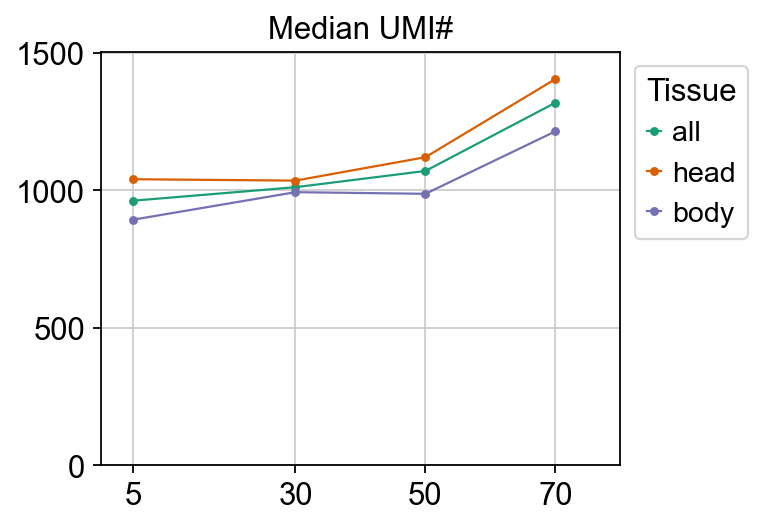

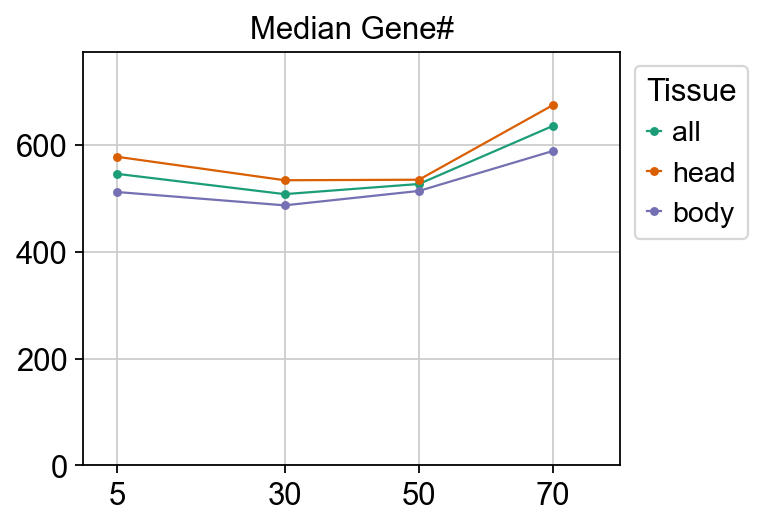

In [157]:
with rc_context({'figure.figsize': (5, 3.5)}):
    for countType in ['total_counts', 'n_genes_by_counts']:
        fig, ax = plt.subplots()

        for i, tissue in enumerate(countAllCells_Df.tissue.value_counts().index):
            df=countAllCells_Df[countAllCells_Df.tissue == tissue]
            plt.plot(df.age.to_list(), df[countType].to_list(), label = tissue, marker='o', linewidth=1, markersize=3, c=dark2Color_L[i])

        plt.xticks([5,30,50,70])
        plt.xlim(0, 80)
        plt.ylim(0, countAllCells_Df[countType].max()+100)

        plt.legend(bbox_to_anchor=(1.0, 1.0), title='Tissue')
        plt.title(f'Median {countName_D[countType]}')
        plt.tight_layout()
        plt.savefig(f'{figure5PicFolder}/Median_{countType}_allCells.pdf')
        plt.show()

**Separate different batches**

In [15]:
count_Df=pd.DataFrame(adata_headBody.obs.groupby(by='sampleGroup').median())[ ['total_counts', 'n_genes_by_counts'] ] # , 


tissueCol_L=[]
ageCol_L=[]
for sampleGroup in count_Df.index:
    # print(sampleGroup)
    if 'AFCA' not in sampleGroup:
        ageCol_L.append('5')
        if 'head' in sampleGroup.lower():
            tissueCol_L.append('head')
        else: tissueCol_L.append('body')
        
    else:
        ageCol_L.append(sampleGroup.split('_')[-2])
        tissueCol_L.append(sampleGroup.split('_')[2])

count_Df['sampleGroup'] =count_Df.index.to_list()
count_Df['tissue'] = pd.Categorical(tissueCol_L)
count_Df['age'] = pd.Categorical(ageCol_L)

count_Df

total_counts  n_genes_by_counts  \
sampleGroup                                                
AFCA_female_body_30_S1         1247.5              595.0   
AFCA_female_body_30_S2         1137.0              555.0   
AFCA_female_body_30_S3         1099.0              547.0   
AFCA_female_body_30_S4         1190.0              575.0   
AFCA_female_body_30_S5         1084.0              535.0   
...                               ...                ...   
FCA5_Male_Adult_Head2          1017.0              563.0   
FCA6_Male_Adult_Head3           987.0              554.0   
FCA7_Female_Adult_Head1        1008.0              584.0   
FCA8_Female_Adult_Head2        1011.0              577.0   
FCA9_Female_Adult_Head3        1009.0              579.0   

                                     sampleGroup tissue age  
sampleGroup                                                  
AFCA_female_body_30_S1    AFCA_female_body_30_S1   body  30  
AFCA_female_body_30_S2    AFCA_female_body_30_S2   body  30  
AFCA_female_body_30_S3    AFCA_female_body_30_S3   body  30  
AFCA_female_body_30_S4    AFCA_female_body_30_S4   body  30  
AFCA_female_body_30_S5    AFCA_female_body_30_S5   body  30  
...                                          ...    ...  ..  
FCA5_Male_Adult_Head2      FCA5_Male_Adult_Head2   head   5  
FCA6_Male_Adult_Head3      FCA6_Male_Adult_Head3   head   5  
FCA7_Female_Adult_Head1  FCA7_Female_Adult_Head1   head   5  
FCA8_Female_Adult_Head2  FCA8_Female_Adult_Head2   head   5  
FCA9_Female_Adult_Head3  FCA9_Female_Adult_Head3   head   5  

[98 rows x 5 columns]

In [16]:
count_long_Df=count_Df.melt(var_name='countType', value_name='counts', value_vars=['total_counts', 'n_genes_by_counts'], id_vars=['sampleGroup', 'tissue', 'age']) # var_name=['total_counts', 'n_genes_by_counts']
count_long_Df['age']=count_long_Df.age.astype(int)
count_long_Df

sampleGroup tissue  age          countType  counts
0     AFCA_female_body_30_S1   body   30       total_counts  1247.5
1     AFCA_female_body_30_S2   body   30       total_counts  1137.0
2     AFCA_female_body_30_S3   body   30       total_counts  1099.0
3     AFCA_female_body_30_S4   body   30       total_counts  1190.0
4     AFCA_female_body_30_S5   body   30       total_counts  1084.0
..                       ...    ...  ...                ...     ...
191    FCA5_Male_Adult_Head2   head    5  n_genes_by_counts   563.0
192    FCA6_Male_Adult_Head3   head    5  n_genes_by_counts   554.0
193  FCA7_Female_Adult_Head1   head    5  n_genes_by_counts   584.0
194  FCA8_Female_Adult_Head2   head    5  n_genes_by_counts   577.0
195  FCA9_Female_Adult_Head3   head    5  n_genes_by_counts   579.0

[196 rows x 5 columns]

total_counts


<Figure size 480x240 with 0 Axes>

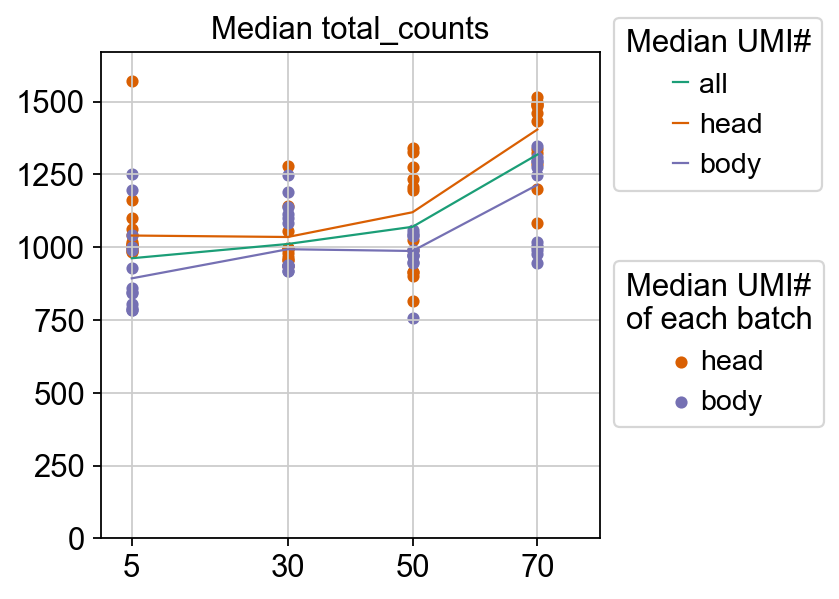

n_genes_by_counts


<Figure size 480x240 with 0 Axes>

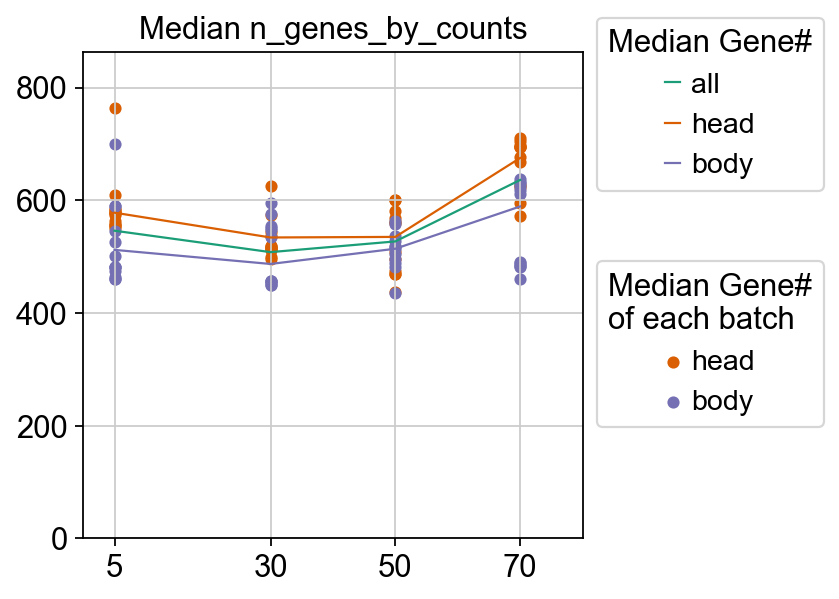

In [17]:
# with rc_context({'figure.figsize': (6, 3.5)}):
    # fig, axs = plt.subplots(1, 2)
    
for countType in ['total_counts', 'n_genes_by_counts']:
    print(countType)

    plt.figure(figsize=(6, 3))
    fig, ax = plt.subplots()


    ### median of all/head/body cells
    lineStyle_L=['-', '-', '-']
    marker_L=['o', '^', 's']
    plot_L=[]
    plotLine_L=[]
    plotDot_L=[]

    for i, tissue in enumerate(countAllCells_Df.tissue.value_counts().index):
    # for i, tissue in enumerate(['head', 'body']):
        df=countAllCells_Df[countAllCells_Df.tissue == tissue]


        lineplot, =plt.plot(df.age.to_list(), df[countType].to_list(),  label = tissue, linewidth=1, linestyle=lineStyle_L[i], c=dark2Color_L[i], ) # marker=marker_L[i] 
        plotLine_L.append(lineplot)
        # ax.legend([line],['solid line'])

        ### median values from each batch
        if tissue != 'all':
            df = count_long_Df[count_long_Df.countType == countType]
            dotplot=plt.scatter( df[df.tissue == tissue].age.to_list(), df[df.tissue == tissue].counts.to_list(), c=dark2Color_L[i], s=20, label = tissue ) # , 
            plotDot_L.append(dotplot)
            # plt.legend(title="Tissue", )


    plt.xticks([5,30,50,70])
    plt.xlim(0, 80)
    plt.ylim(0, df.counts.max()+100)
    # plt.legend(loc=2, prop={'size': 6})

    legend1 = plt.legend(handles=plotLine_L, title=f'Median {countName_D[countType]}', bbox_to_anchor=(1.0, 1.0, 0.1, 0.1)) #   fontsize=14, title_fontsize=14) # , prop={'size': 30}
    ax.add_artist(legend1)
    plt.legend(handles=plotDot_L, title=f'Median {countName_D[countType]}\nof each batch', bbox_to_anchor=(1.0, 0.5, 0.1, 0.1)) # loc='best', bbox_to_anchor=(1.2, 0.5, 0.1, 0.1), fontsize=14, title_fontsize=14)
    plt.title(f'Median {countType}')
    
    #plt.tight_layout()
    
    plt.savefig(f'{figure5PicFolder}/Median_{countType}_allCells_batch.pdf', bbox_inches='tight')
    plt.show()


total_counts


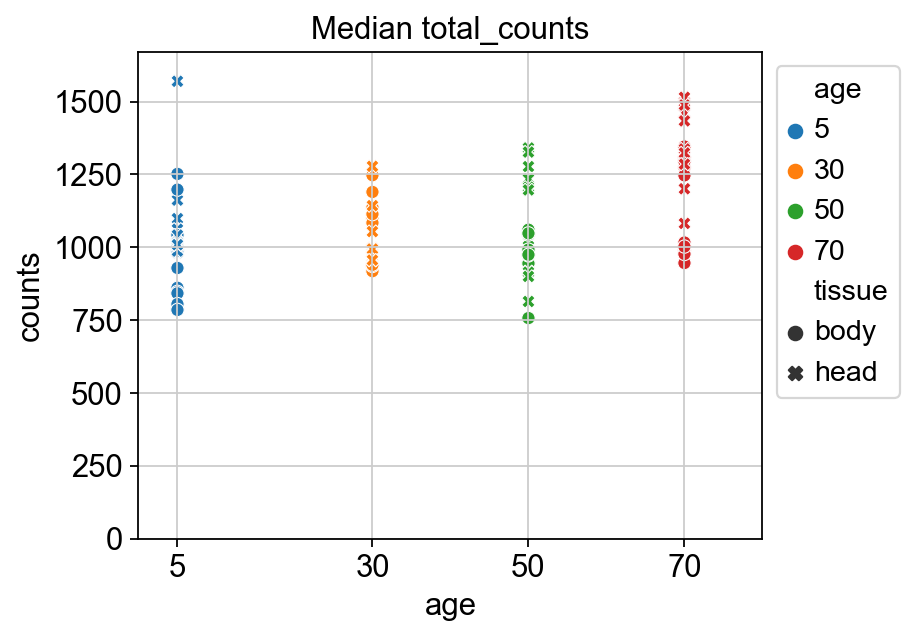

n_genes_by_counts


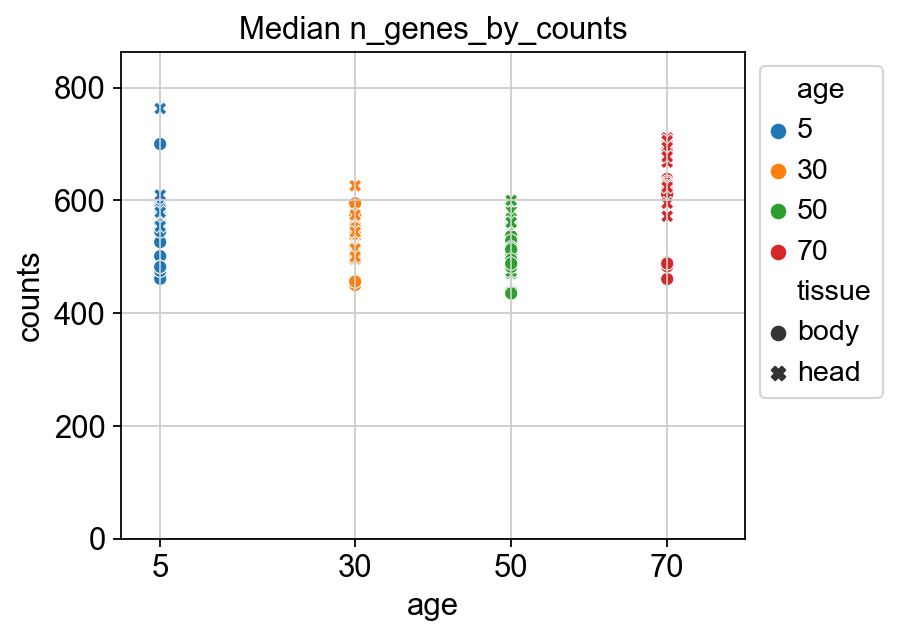

In [18]:
with rc_context({'figure.figsize': (5, 4)}):
    for countType in count_long_Df.countType.value_counts().index:
        print(countType)

        df = count_long_Df[count_long_Df.countType == countType]
        sns.scatterplot(data=df[df.countType == countType], x='age', y= 'counts', hue='age', palette=ageColor_L, style='tissue') # ylim=
        
        
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.xlim(0, 80)
        plt.ylim(0, df.counts.max()+100)
        plt.xticks([5,30,50,70])
        plt.title(f'Median {countType}')
        plt.show()

/var/folders/jj/t95qp6v1343877pd7n071t200000gp/T/ipykernel_63956/998900168.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


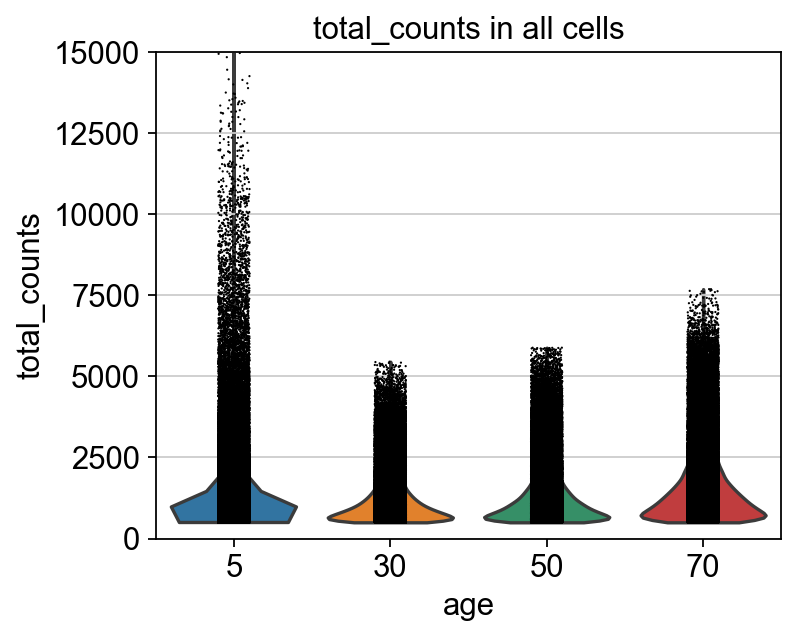

/var/folders/jj/t95qp6v1343877pd7n071t200000gp/T/ipykernel_63956/998900168.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


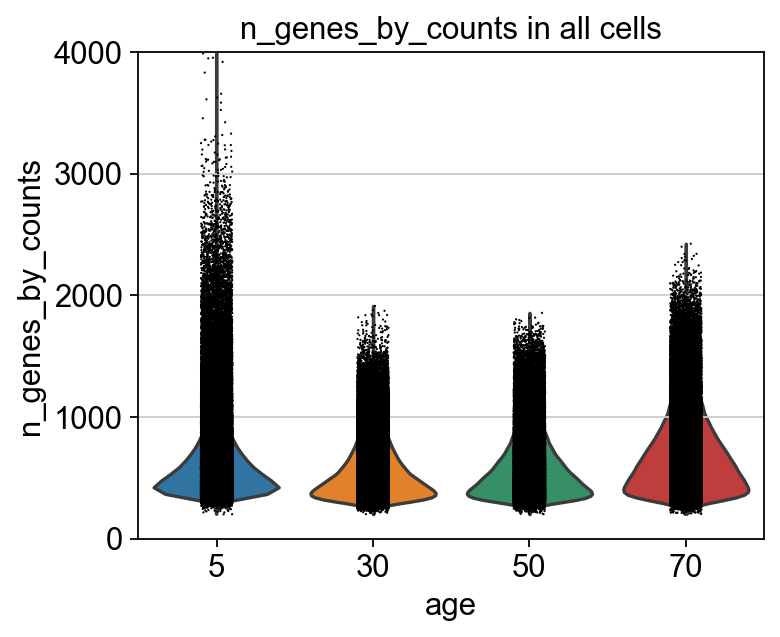

In [18]:
with rc_context({'figure.figsize': (5, 4)}):
    g=sc.pl.violin(adata_headBody, keys='total_counts', groupby='age', show=False)
    plt.title(f'total_counts in all cells')
    plt.ylim(0, 15000)
    plt.tight_layout()
    plt.savefig(f'{figure5PicFolder}/violin_total_counts_allCells.pdf')
    plt.show()
    
    g=sc.pl.violin(adata_headBody, keys='n_genes_by_counts', groupby='age', show=False)
    plt.title(f'n_genes_by_counts in all cells')
    plt.ylim(0, 4000)
    plt.tight_layout()
    plt.savefig(f'{figure5PicFolder}/violin_n_genes_by_counts_allCells.pdf')
    plt.show()

/var/folders/jj/t95qp6v1343877pd7n071t200000gp/T/ipykernel_10496/78978395.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


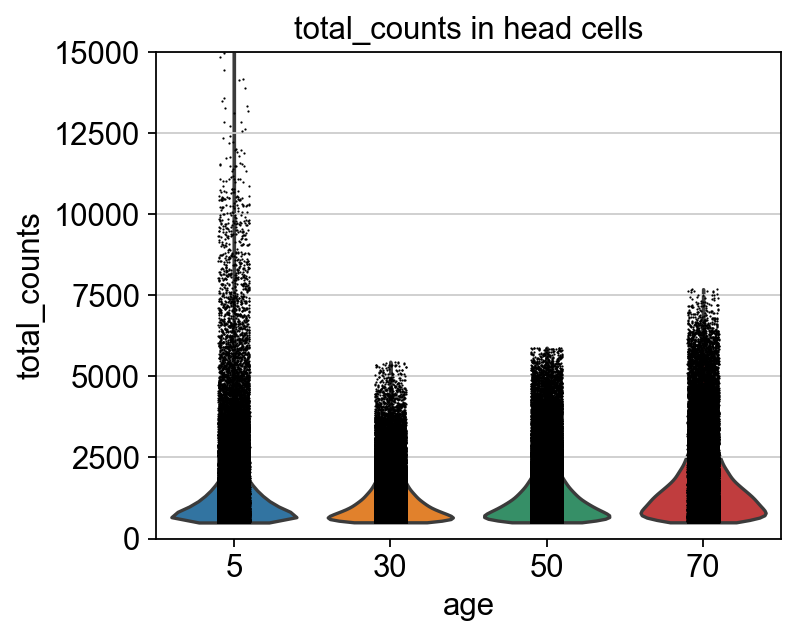

/var/folders/jj/t95qp6v1343877pd7n071t200000gp/T/ipykernel_10496/78978395.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


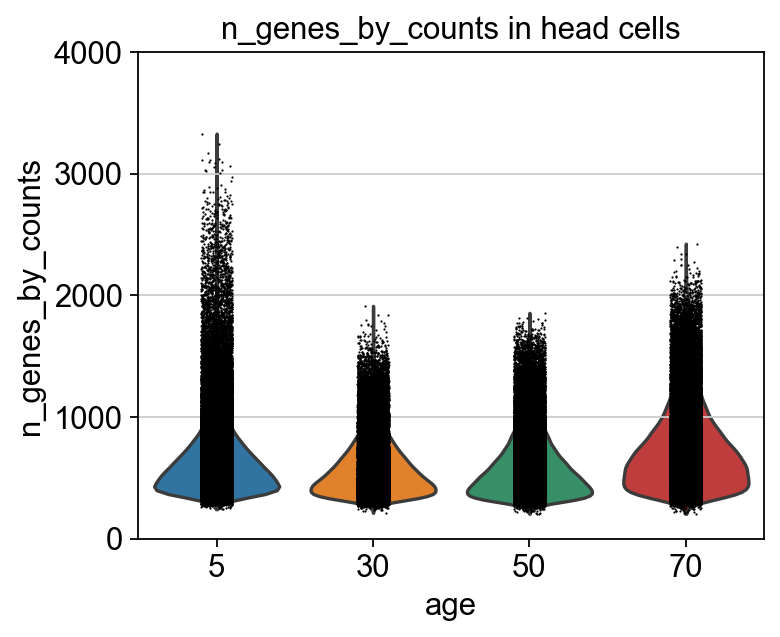

/var/folders/jj/t95qp6v1343877pd7n071t200000gp/T/ipykernel_10496/78978395.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


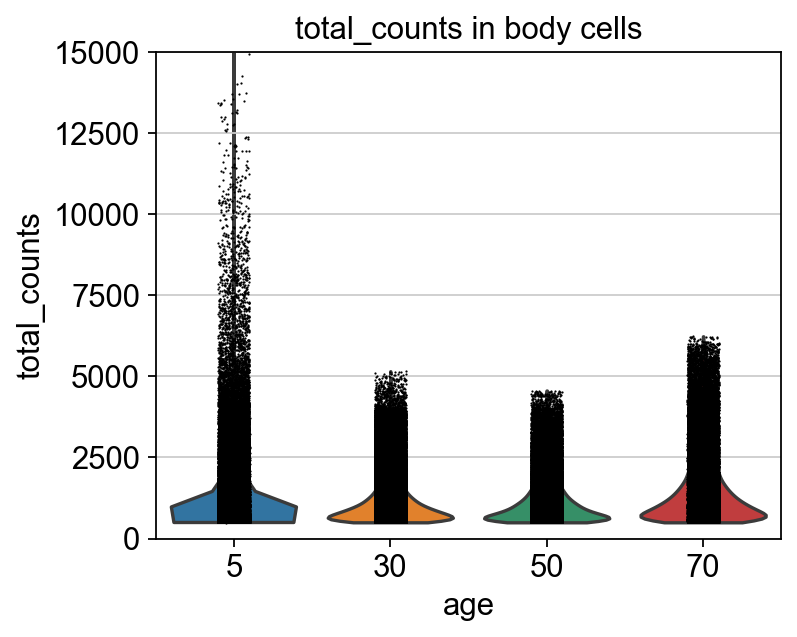

/var/folders/jj/t95qp6v1343877pd7n071t200000gp/T/ipykernel_10496/78978395.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


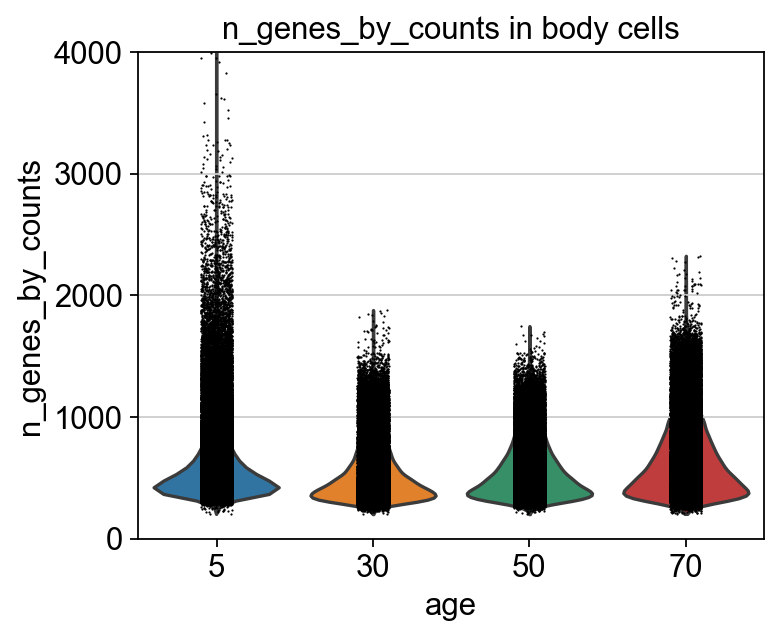

In [144]:
with rc_context({'figure.figsize': (5, 4)}):
    for tissue in ['head', 'body']:
        for countType in ['total_counts', 'n_genes_by_counts']:
            if countType == 'total_counts': ylim=15000
            else: ylim=4000
            
            g=sc.pl.violin(adata_headBody[adata_headBody.obs.tissue == tissue], keys=countType, groupby='age', show=False)
            plt.title(f'{countType} in {tissue} cells')
            plt.ylim(0, ylim)
            plt.tight_layout()
            plt.savefig(f'{figure5PicFolder}/violin_{countType}_{tissue}.pdf')
            plt.show()

        # g=sc.pl.violin(adata_headBody[adata_headBody.obs.tissue == tissue], keys='n_genes_by_counts', groupby='age', show=False)
        # plt.title(f'n_genes_by_counts in all cells')
        # plt.ylim(0, 4000)
        # plt.tight_layout()
        # plt.savefig(f'{figure5PicFolder}/violin_n_genes_by_counts_{tissue}.pdf')
        # plt.show()

**Stat: all cells**

In [165]:
counts_D={}
for countType in ['total_counts', 'n_genes_by_counts']:
    counts_D[countType]={}
    for i, age in enumerate(age_L):   
        counts_D[countType][age] = adata_headBody[adata_headBody.obs.age == age].obs[countType].to_list()
        
# counts_D

In [166]:
for countType in ['total_counts', 'n_genes_by_counts']:
    for i, age in enumerate(age_L[:-1]):
        print(f'{countType} comparsion: {age_L[0]}d/{age_L[i+1]}d comparsion')
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]]))
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]], alternative='greater'))
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]], alternative='less'))
        print()

total_counts comparsion: 5d/30d comparsion
RanksumsResult(statistic=-19.55003220686247, pvalue=4.1226059063521273e-85)
RanksumsResult(statistic=-19.55003220686247, pvalue=1.0)
RanksumsResult(statistic=-19.55003220686247, pvalue=2.0613029531760637e-85)

total_counts comparsion: 5d/50d comparsion
RanksumsResult(statistic=-37.55658606342982, pvalue=1.0999694917307383e-308)
RanksumsResult(statistic=-37.55658606342982, pvalue=1.0)
RanksumsResult(statistic=-37.55658606342982, pvalue=5.49984745865369e-309)

total_counts comparsion: 5d/70d comparsion
RanksumsResult(statistic=-110.13802042382017, pvalue=0.0)
RanksumsResult(statistic=-110.13802042382017, pvalue=1.0)
RanksumsResult(statistic=-110.13802042382017, pvalue=0.0)

n_genes_by_counts comparsion: 5d/30d comparsion
RanksumsResult(statistic=60.097995508025846, pvalue=0.0)
RanksumsResult(statistic=60.097995508025846, pvalue=0.0)
RanksumsResult(statistic=60.097995508025846, pvalue=1.0)

n_genes_by_counts comparsion: 5d/50d comparsion
Ranksums

**Stat: head cells**

In [158]:
counts_D={}
for countType in ['total_counts', 'n_genes_by_counts']:
    counts_D[countType]={}
    for i, age in enumerate(age_L):   
        counts_D[countType][age] = adata_headBody[(adata_headBody.obs.age == age) & (adata_headBody.obs.tissue == 'head')].obs[countType].to_list()
        
# counts_D

In [161]:
for countType in ['total_counts', 'n_genes_by_counts']:
    for i, age in enumerate(age_L[:-1]):
        print(f'{countType} comparsion: {age_L[0]}d/{age_L[i+1]}d comparsion')
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]]))
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]], alternative='greater'))
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]], alternative='less'))
        print()

total_counts comparsion: 5d/30d comparsion
RanksumsResult(statistic=4.100633824306955, pvalue=4.120200831282684e-05)
RanksumsResult(statistic=4.100633824306955, pvalue=2.060100415641342e-05)
RanksumsResult(statistic=4.100633824306955, pvalue=0.9999793989958435)

total_counts comparsion: 5d/50d comparsion
RanksumsResult(statistic=-24.84910627996518, pvalue=2.6440321066951955e-136)
RanksumsResult(statistic=-24.84910627996518, pvalue=1.0)
RanksumsResult(statistic=-24.84910627996518, pvalue=1.3220160533475977e-136)

total_counts comparsion: 5d/70d comparsion
RanksumsResult(statistic=-82.00830472709457, pvalue=0.0)
RanksumsResult(statistic=-82.00830472709457, pvalue=1.0)
RanksumsResult(statistic=-82.00830472709457, pvalue=0.0)

n_genes_by_counts comparsion: 5d/30d comparsion
RanksumsResult(statistic=41.79607399047764, pvalue=0.0)
RanksumsResult(statistic=41.79607399047764, pvalue=0.0)
RanksumsResult(statistic=41.79607399047764, pvalue=1.0)

n_genes_by_counts comparsion: 5d/50d comparsion
Ra

**Stat: body cells**

In [162]:
counts_D={}
for countType in ['total_counts', 'n_genes_by_counts']:
    counts_D[countType]={}
    for i, age in enumerate(age_L):   
        counts_D[countType][age] = adata_headBody[(adata_headBody.obs.age == age) & (adata_headBody.obs.tissue == 'body')].obs[countType].to_list()
        
# counts_D

In [164]:
for countType in ['total_counts', 'n_genes_by_counts']:
    for i, age in enumerate(age_L[:-1]):
        print(f'{countType} comparsion: {age_L[0]}d/{age_L[i+1]}d comparsion')
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]]))
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]], alternative='greater'))
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]], alternative='less'))
        print()

total_counts comparsion: 5d/30d comparsion
RanksumsResult(statistic=-33.00534340887937, pvalue=6.808104596698957e-239)
RanksumsResult(statistic=-33.00534340887937, pvalue=1.0)
RanksumsResult(statistic=-33.00534340887937, pvalue=3.4040522983494786e-239)

total_counts comparsion: 5d/50d comparsion
RanksumsResult(statistic=-19.41803764405624, pvalue=5.432646162767842e-84)
RanksumsResult(statistic=-19.41803764405624, pvalue=1.0)
RanksumsResult(statistic=-19.41803764405624, pvalue=2.716323081383921e-84)

total_counts comparsion: 5d/70d comparsion
RanksumsResult(statistic=-73.22841610239097, pvalue=0.0)
RanksumsResult(statistic=-73.22841610239097, pvalue=1.0)
RanksumsResult(statistic=-73.22841610239097, pvalue=0.0)

n_genes_by_counts comparsion: 5d/30d comparsion
RanksumsResult(statistic=40.09359607956981, pvalue=0.0)
RanksumsResult(statistic=40.09359607956981, pvalue=0.0)
RanksumsResult(statistic=40.09359607956981, pvalue=1.0)

n_genes_by_counts comparsion: 5d/50d comparsion
RanksumsResult(

### Check UMI/gene# using broad annotations

In [12]:
adata_headBody=sc.read(f'{allHeadBodyDataFolder}/adata_headBody_S_v1.0.h5ad')

In [13]:
countName_D={'total_counts':'UMI#', 'n_genes_by_counts':'Gene#'}

In [14]:
for cellType in adata_headBody.obs.afca_annotation_broad.cat.categories:
    print(cellType)

CNS neuron
cardial cell
epithelial cell
excretory system
fat cell
female germline cell
female reproductive system
gland
glial cell
hemocyte
male germline cell
male reproductive system
muscle cell
oenocyte
sensory neuron
somatic precursor cell
tracheal cell


**Check CNS neuron**

In [15]:
adata_CNS=adata_headBody[adata_headBody.obs.afca_annotation_broad == 'CNS neuron' ]

In [16]:
countAllCells_Df=pd.DataFrame(adata_CNS.obs.groupby(by='age').median())[ ['total_counts', 'n_genes_by_counts'] ]
countAllCells_Df['age'] = countAllCells_Df.index.to_list()
countAllCells_Df['age']=countAllCells_Df['age'].astype(int)
countAllCells_Df

/var/folders/jj/t95qp6v1343877pd7n071t200000gp/T/ipykernel_5056/2256919264.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  countAllCells_Df=pd.DataFrame(adata_CNS.obs.groupby(by='age').median())[ ['total_counts', 'n_genes_by_counts'] ]


total_counts  n_genes_by_counts  age
age                                      
5          1188.0              643.0    5
30         1062.0              556.0   30
50         1060.0              527.0   50
70         1246.0              626.0   70

<Figure size 480x240 with 0 Axes>

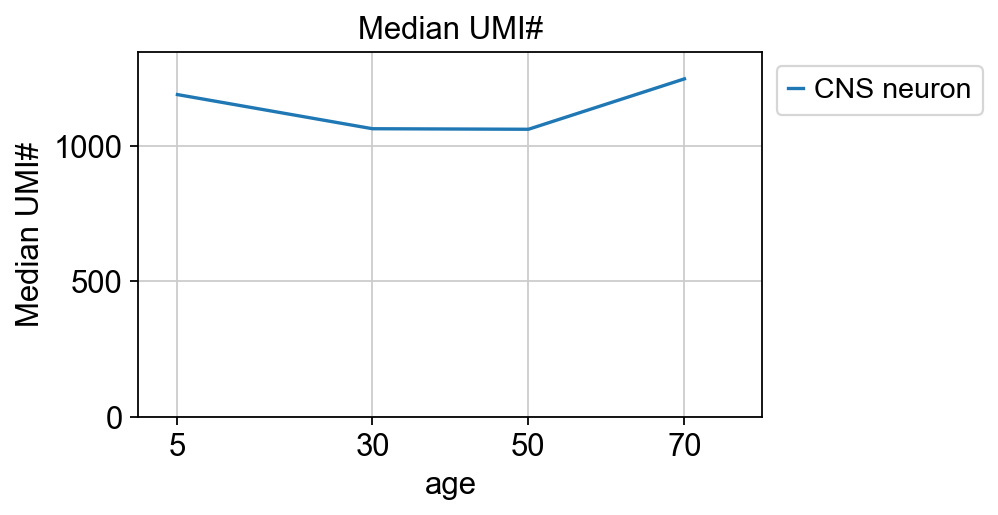

<Figure size 480x240 with 0 Axes>

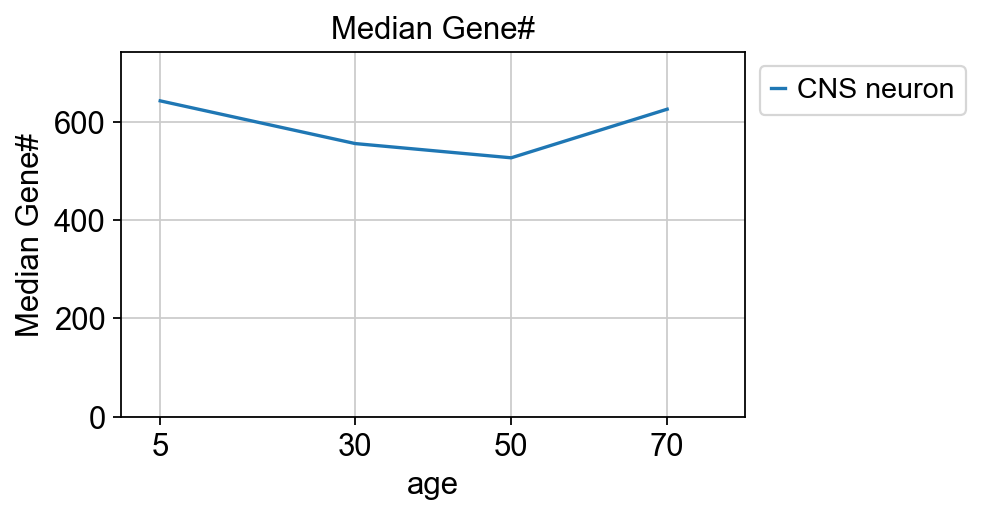

In [17]:
with rc_context({'figure.figsize': (5, 3)}):
    for countType in ['total_counts', 'n_genes_by_counts']:
        plt.figure(figsize=(6, 3))
        fig, ax = plt.subplots()

        sns.lineplot(data=countAllCells_Df, x='age', y=countType, label='CNS neuron')
        plt.xlim(0, 80)
        plt.xticks([5,30,50,70])
        plt.ylim(0, countAllCells_Df[countType].max()+100)
        plt.ylabel(f'Median {countName_D[countType]}')

        plt.legend(bbox_to_anchor=(1.0, 0.9, 0.1, 0.1))
        plt.title(f'Median {countName_D[countType]}')

        # plt.tight_layout()

        plt.savefig(f'{figure5PicFolder}/lineplot_{countType}_CNS_neuron_median.pdf', bbox_inches='tight') # , bbox_inches='tight'
        plt.show()

In [33]:
counts_D={}
for countType in ['total_counts', 'n_genes_by_counts']:
    counts_D[countType]={}
    for i, age in enumerate(age_L):   
        counts_D[countType][age] = adata_CNS[adata_CNS.obs.age == age].obs[countType].to_list()
        
# counts_D

In [34]:
for countType in ['total_counts', 'n_genes_by_counts']:
    for i, age in enumerate(age_L[:-1]):
        print(f'{countType} comparsion: {age_L[0]}d/{age_L[i+1]}d comparsion')
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]]))
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]], alternative='greater'))
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]], alternative='less'))
        print()

total_counts comparsion: 5d/30d comparsion
RanksumsResult(statistic=32.711724370295585, pvalue=1.0639611269415879e-234)
RanksumsResult(statistic=32.711724370295585, pvalue=5.319805634707939e-235)
RanksumsResult(statistic=32.711724370295585, pvalue=1.0)

total_counts comparsion: 5d/50d comparsion
RanksumsResult(statistic=30.90081997650856, pvalue=1.1645423852539688e-209)
RanksumsResult(statistic=30.90081997650856, pvalue=5.822711926269844e-210)
RanksumsResult(statistic=30.90081997650856, pvalue=1.0)

total_counts comparsion: 5d/70d comparsion
RanksumsResult(statistic=-9.247495285553859, pvalue=2.2981470692388644e-20)
RanksumsResult(statistic=-9.247495285553859, pvalue=1.0)
RanksumsResult(statistic=-9.247495285553859, pvalue=1.1490735346194322e-20)

n_genes_by_counts comparsion: 5d/30d comparsion
RanksumsResult(statistic=61.95153710085522, pvalue=0.0)
RanksumsResult(statistic=61.95153710085522, pvalue=0.0)
RanksumsResult(statistic=61.95153710085522, pvalue=1.0)

n_genes_by_counts compars

/var/folders/jj/t95qp6v1343877pd7n071t200000gp/T/ipykernel_29022/3143733956.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


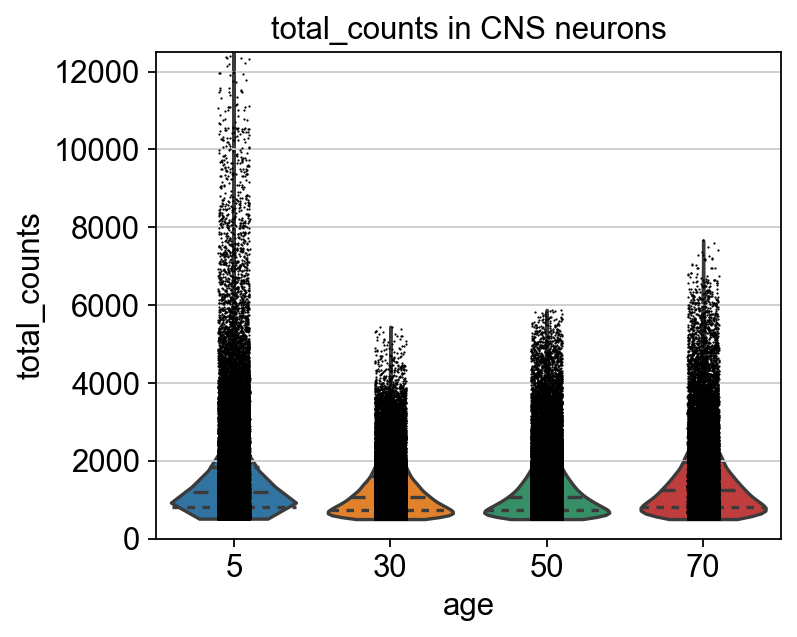

/var/folders/jj/t95qp6v1343877pd7n071t200000gp/T/ipykernel_29022/3143733956.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


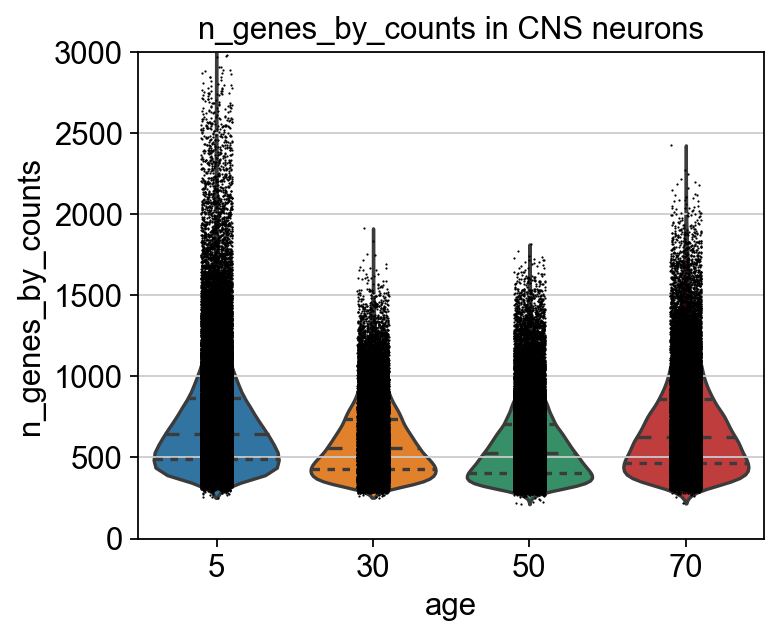

In [104]:
with rc_context({'figure.figsize': (5, 4)}):
    g=sc.pl.violin(adata_CNS, keys='total_counts', groupby='age', inner="quartile", show=False)
    plt.title(f'total_counts in CNS neurons')
    plt.ylim(0, 12500)
    plt.tight_layout()
    plt.savefig(f'{figure5PicFolder}/violin_total_counts_CNS_neuron.pdf')
    plt.savefig(f'{figure5PicFolder}/violin_total_counts_CNS_neuron.png')
    plt.show()
    
    g=sc.pl.violin(adata_CNS, keys='n_genes_by_counts', groupby='age', inner="quartile",show=False)
    plt.title(f'n_genes_by_counts in CNS neurons')
    plt.ylim(0, 3000)
    plt.tight_layout()
    plt.savefig(f'{figure5PicFolder}/violin_n_genes_by_counts_CNS_neuron.pdf')
    plt.savefig(f'{figure5PicFolder}/violin_n_genes_by_counts_CNS_neuron.png')
    plt.show()

/var/folders/jj/t95qp6v1343877pd7n071t200000gp/T/ipykernel_29022/2336469415.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


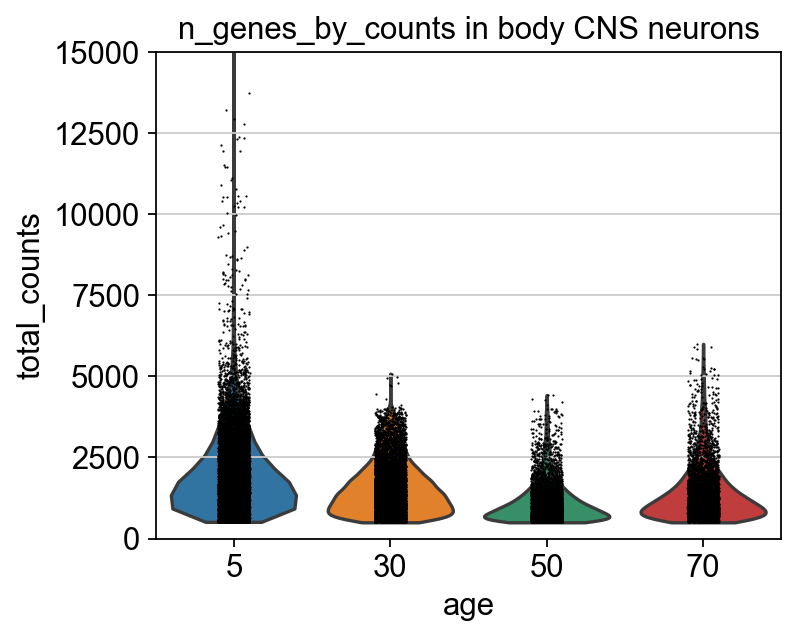

/var/folders/jj/t95qp6v1343877pd7n071t200000gp/T/ipykernel_29022/2336469415.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


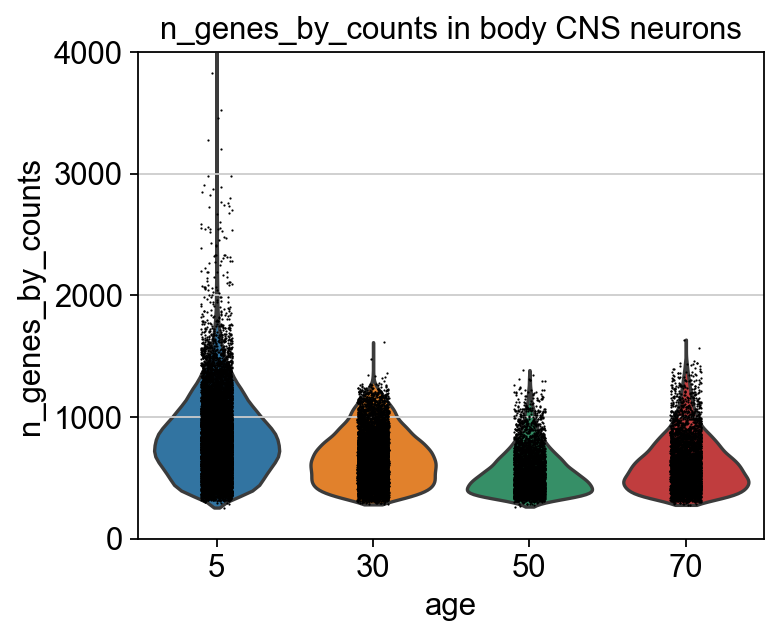

/var/folders/jj/t95qp6v1343877pd7n071t200000gp/T/ipykernel_29022/2336469415.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


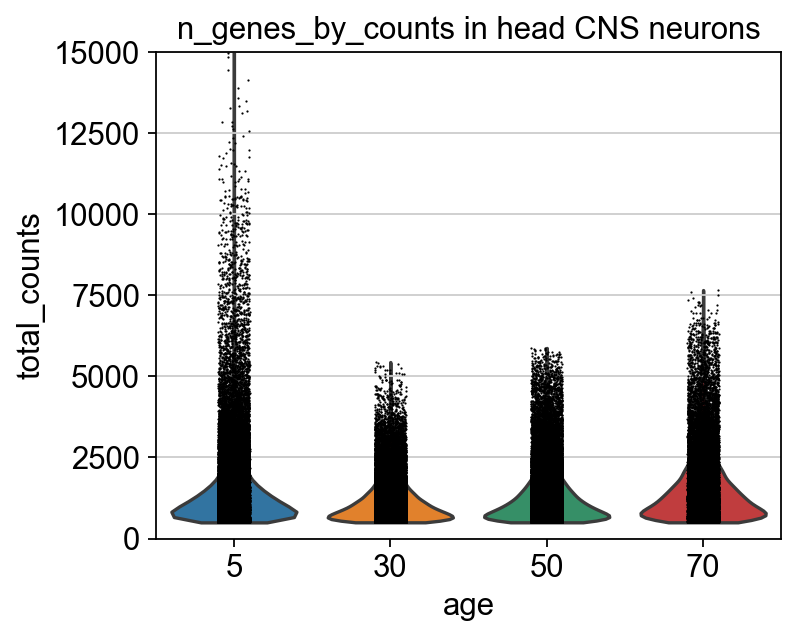

/var/folders/jj/t95qp6v1343877pd7n071t200000gp/T/ipykernel_29022/2336469415.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


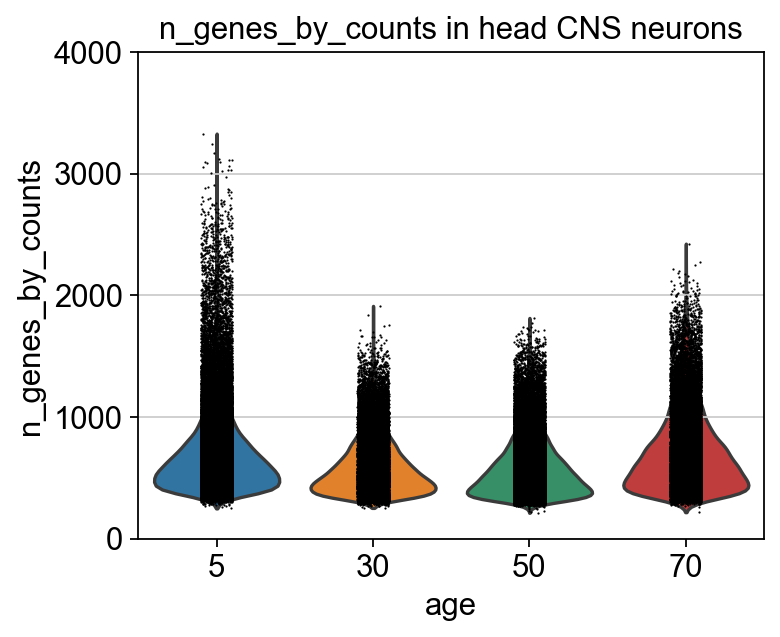

In [36]:
with rc_context({'figure.figsize': (5, 4)}):
    for tissue in ['body', 'head']:
        adata=adata_CNS[adata_CNS.obs.tissue == tissue]
        g=sc.pl.violin(adata, keys='total_counts', groupby='age', show=False, inner="quartile",)
        plt.title(f'n_genes_by_counts in {tissue} CNS neurons')
        plt.ylim(0, 15000)
        plt.savefig(f'{figure5PicFolder}/violin_total_counts_CNS_neuron_{tissue}.pdf')
        plt.savefig(f'{figure5PicFolder}/violin_total_counts_CNS_neuron_{tissue}.png')
        plt.tight_layout()
        plt.show()
        # plt.close()

        g=sc.pl.violin(adata, keys='n_genes_by_counts', groupby='age', show=False, inner="quartile",)
        plt.title(f'n_genes_by_counts in {tissue} CNS neurons')
        plt.ylim(0, 4000)
        plt.savefig(f'{figure5PicFolder}/violin_n_genes_by_counts_CNS_neuron_{tissue}.pdf')
        plt.savefig(f'{figure5PicFolder}/violin_n_genes_by_counts_CNS_neuron_{tissue}.png')
        plt.tight_layout()
        plt.show()

In [37]:
adata_CNS_head = adata_CNS[adata_CNS.obs.tissue == 'head']

In [57]:
countAllCells_Df=pd.DataFrame(adata_CNS_head.obs.groupby(by='age').median())[ ['total_counts', 'n_genes_by_counts'] ]
countAllCells_Df['age'] = countAllCells_Df.index.to_list()
countAllCells_Df['age']=countAllCells_Df['age'].astype(str)
countAllCells_Df

/var/folders/jj/t95qp6v1343877pd7n071t200000gp/T/ipykernel_29022/2290486291.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  countAllCells_Df=pd.DataFrame(adata_CNS_head.obs.groupby(by='age').median())[ ['total_counts', 'n_genes_by_counts'] ]


total_counts  n_genes_by_counts age
age                                     
5          1118.0              618.0   5
30         1003.0              536.0  30
50         1076.0              530.0  50
70         1265.0              637.0  70

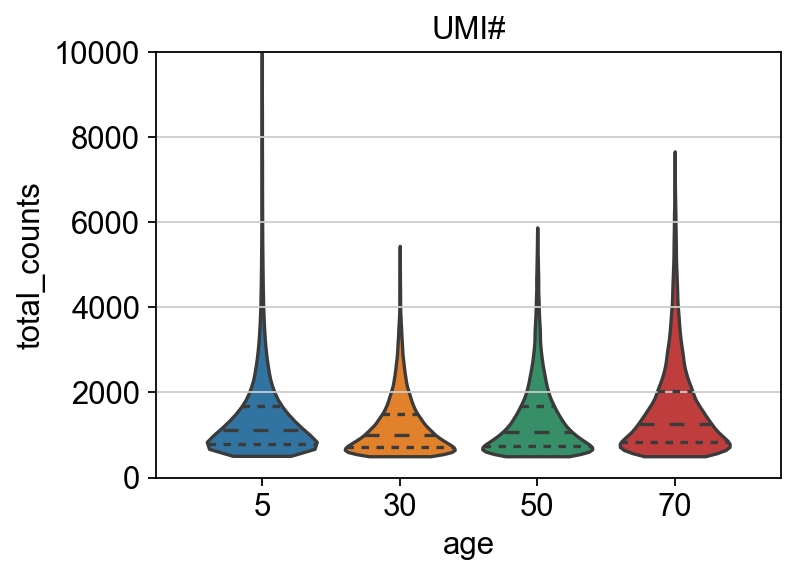

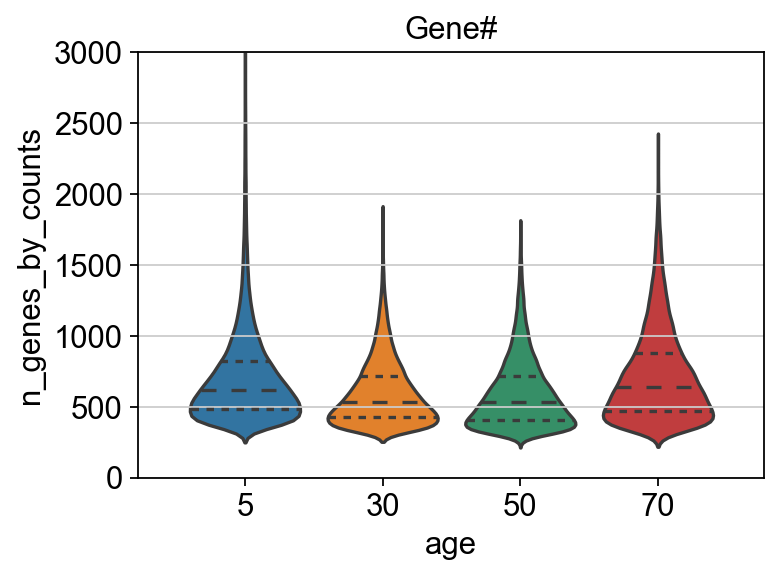

In [100]:
with rc_context({'figure.figsize': (5, 3.5)}):
    for countType in ['total_counts', 'n_genes_by_counts']:
        # plt.figure(figsize=(6, 3))
        # fig, ax = plt.subplots()

        g=sc.pl.violin(adata, keys=countType, groupby='age', show=False, size=0, inner="quartile",)
        
        if countType == 'total_counts': ylim=10000
        else: ylim=3000
        plt.ylim(0, ylim)
        
        g.margins(0.1, 0.03)
        # g.legend().set_visible(False)

        # plt.legend(bbox_to_anchor=(1.0, 0.9))
        plt.title(f'{countName_D[countType]}')

        # plt.tight_layout()

        plt.savefig(f'{figure5PicFolder}/violin__{countType}_CNS_neuron_head_wMedian_noDots.pdf', bbox_inches='tight') 
        plt.savefig(f'{figure5PicFolder}/violin__{countType}_CNS_neuron_head_wMedian_noDots.png', bbox_inches='tight') 
        plt.show()

In [38]:
counts_D={}
for countType in ['total_counts', 'n_genes_by_counts']:
    counts_D[countType]={}
    for i, age in enumerate(age_L):   
        counts_D[countType][age] = adata_CNS_head[adata_CNS_head.obs.age == age].obs[countType].to_list()
        
# counts_D

In [39]:
for countType in ['total_counts', 'n_genes_by_counts']:
    for i, age in enumerate(age_L[:-1]):
        print(f'{countType} comparsion: {age_L[0]}d/{age_L[i+1]}d comparsion')
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]]))
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]], alternative='greater'))
        print(ranksums(counts_D[countType][age_L[0]], counts_D[countType][age_L[i+1]], alternative='less'))
        print()

total_counts comparsion: 5d/30d comparsion
RanksumsResult(statistic=29.02523079628127, pvalue=3.1616387691116735e-185)
RanksumsResult(statistic=29.02523079628127, pvalue=1.5808193845558367e-185)
RanksumsResult(statistic=29.02523079628127, pvalue=1.0)

total_counts comparsion: 5d/50d comparsion
RanksumsResult(statistic=10.520698835183298, pvalue=6.935723062113031e-26)
RanksumsResult(statistic=10.520698835183298, pvalue=3.4678615310565156e-26)
RanksumsResult(statistic=10.520698835183298, pvalue=1.0)

total_counts comparsion: 5d/70d comparsion
RanksumsResult(statistic=-24.413067438221983, pvalue=1.2425125013456678e-131)
RanksumsResult(statistic=-24.413067438221983, pvalue=1.0)
RanksumsResult(statistic=-24.413067438221983, pvalue=6.212562506728339e-132)

n_genes_by_counts comparsion: 5d/30d comparsion
RanksumsResult(statistic=54.46456480400548, pvalue=0.0)
RanksumsResult(statistic=54.46456480400548, pvalue=0.0)
RanksumsResult(statistic=54.46456480400548, pvalue=1.0)

n_genes_by_counts comp

# Fig 5C: UMI/gene#

## UMI#/gene# in cell-type levels

In [18]:
adata_headBody=sc.read(f'{allHeadBodyDataFolder}/adata_headBody_S_v1.0.h5ad')

In [19]:
countName_D={'total_counts':'UMI#', 'n_genes_by_counts':'Gene#'}

### Normalize median UMI#/gene#

In [20]:
celltypeN500_L = pd.read_csv(f'{figure2DataFolder}/cellN/celltype_cellN_n500.csv').annotation.to_list()

In [21]:
cellTypeOrder_L=[x.strip() for x in open(f'{figureDataFolder}/agingFeature_cellTypeName_modified.list')]
cellTypeOrderSelected_L=[x.strip() for x in open(f'{figureDataFolder}/agingFeature_cellTypeName_modified_selected.list')]

In [22]:
normalRatio_Df=pd.read_csv(f'{figure2DataFolder}/cellN/headBody_normalRatioDf_normalizeTo5d.csv', index_col=0).iloc[:,1:]
normalRatio_Df

annotation  \
cardia (1)                                                                                 cardia (1)   
adult fat body_body                                                               adult fat body_body   
male accessory gland main cell                                         male accessory gland main cell   
enteroblast                                                                               enteroblast   
adult salivary gland                                                             adult salivary gland   
...                                                                                               ...   
visceral muscle of the crop                                               visceral muscle of the crop   
muscle cell                                                                               muscle cell   
germline cell                                                                           germline cell   
adult reticular neuropil associated glial cell_...  adult reticular neuropil associated glial cell...   
indirect flight muscle                                                         indirect flight muscle   

                                                    30d/5d_ratio  \
cardia (1)                                              3.366614   
adult fat body_body                                     2.441033   
male accessory gland main cell                          2.174354   
enteroblast                                             1.664538   
adult salivary gland                                    2.402504   
...                                                          ...   
visceral muscle of the crop                            -0.803392   
muscle cell                                            -0.766909   
germline cell                                          -2.107656   
adult reticular neuropil associated glial cell_...      1.084027   
indirect flight muscle                                  0.616862   

                                                    50d/5d_ratio  \
cardia (1)                                              3.970931   
adult fat body_body                                     2.784070   
male accessory gland main cell                          2.545936   
enteroblast                                             2.471348   
adult salivary gland                                    2.364433   
...                                                          ...   
visceral muscle of the crop                            -1.091072   
muscle cell                                            -1.220535   
germline cell                                          -1.261042   
adult reticular neuropil associated glial cell_...     -1.350827   
indirect flight muscle                                 -2.085490   

                                                    70d/5d_ratio tissue  
cardia (1)                                              3.720461   body  
adult fat body_body                                     2.185617   body  
male accessory gland main cell                          0.900669   body  
enteroblast                                             2.500458   body  
adult salivary gland                                    2.241751   body  
...                                                          ...    ...  
visceral muscle of the crop                            -1.644615   body  
muscle cell                                            -1.249407   body  
germline cell                                          -0.698137   body  
adult reticular neuropil associated glial cell_...     -0.445817   body  
indirect flight muscle                                 -2.050574   body  

[112 rows x 5 columns]

In [23]:
obs_Df=adata_headBody.obs
obs_5d_Df=obs_Df[obs_Df.age == '5']
obs_30d_Df=obs_Df[obs_Df.age == '30']
obs_50d_Df=obs_Df[obs_Df.age == '50']
obs_70d_Df=obs_Df[obs_Df.age == '70']

In [24]:
umiMedian_Df = pd.DataFrame(index=adata_headBody.obs.afca_annotation.cat.categories.to_list(), columns=age_L)
geneN_Median_Df = pd.DataFrame(index=adata_headBody.obs.afca_annotation.cat.categories.to_list(), columns=age_L)
for i, cellType in enumerate(umiMedian_Df.index):
    for age in age_L:
        
        ageCelltype_Df=obs_Df[(obs_Df.age == age) & (obs_Df.afca_annotation == cellType)]
        ageCelltype_medianUmi=ageCelltype_Df.total_counts.median()
        ageCelltype_medianGeneN=ageCelltype_Df.n_genes_by_counts.median()
        # print(f'{age}d', '\t', cellType)
        # print(ageCelltype_medianUmi, '\t', ageCelltype_medianGeneN)
        
        umiMedian_Df.loc[cellType, age] = ageCelltype_medianUmi
        geneN_Median_Df.loc[cellType, age] = ageCelltype_medianGeneN
    # print()

In [27]:
# Normalized values
for age in age_L[1:]:
    columnName=f'{age}d/5d_ratio'
    columnNameLog2=f'{age}d/5d_log2ratio'
    
    umiRatio_L=[]
    umiLog2Ratio_L=[]
    geneN_ratio_L=[]
    geneN_log2ratio_L=[]
    
    for i, cellType in enumerate(umiMedian_Df.index):
        ageUmiM=umiMedian_Df.loc[cellType, age]
        refUmiM=umiMedian_Df.loc[cellType, '5']
        umiRatio=ageUmiM/refUmiM
        umiLog2Ratio=np.log2(umiRatio)
        umiRatio_L.append(umiRatio)
        umiLog2Ratio_L.append(umiLog2Ratio)
        
        ageGenenM=geneN_Median_Df.loc[cellType, age]
        refGenenM=geneN_Median_Df.loc[cellType, '5']
        genenRatio=ageGenenM/refGenenM
        genenLog2Ratio=np.log2(genenRatio)
        geneN_ratio_L.append(genenRatio)
        geneN_log2ratio_L.append(genenLog2Ratio)
    
    umiMedian_Df[columnName]=pd.Categorical(umiRatio_L)
    umiMedian_Df[columnNameLog2]=pd.Categorical(umiLog2Ratio_L)
    geneN_Median_Df[columnName]=pd.Categorical(geneN_ratio_L)
    geneN_Median_Df[columnNameLog2]=pd.Categorical(geneN_log2ratio_L)

In [30]:
umiMedian_Df.to_csv(f'{figure5Folder}/headBody_umiMedianRatio.csv')
geneN_Median_Df.to_csv(f'{figure5Folder}/headBody_geneN_MedianRatio.csv')

### Plot normalized results

In [31]:
umiMedian_Df=pd.read_csv(f'{figure5Folder}/headBody_umiMedianRatio.csv', index_col=0)
geneN_Median_Df=pd.read_csv(f'{figure5Folder}/headBody_geneN_MedianRatio.csv', index_col=0)

In [32]:
celltypeN500_L = pd.read_csv(f'{figure2DataFolder}/cellN/celltype_cellN_n500.csv').annotation.to_list()

In [33]:
cellTypeOrder_L=[x.strip() for x in open(f'{figure3DataFolder}/agingFeature_cellTypeName_modified.list')]
cellTypeOrderSelected_L=[x.strip() for x in open(f'{figure3DataFolder}/agingFeature_cellTypeName_modified_selected.list')]

In [34]:
umiMedian_mtx=umiMedian_Df.iloc[:,[5,7,9]]
geneN_Median_mtx=geneN_Median_Df.iloc[:,[5,7,9]]
geneN_Median_mtx

30d/5d_log2ratio  \
16-cell germline cyst in germarium region 2a an...         -0.889491   
CNS surface associated glial cell                          -0.122096   
Johnston organ neuron                                      -0.029088   
Kenyon cell                                                 0.156558   
Poxn neuron                                                -0.240017   
...                                                              ...   
transmedullary neuron Tm9                                  -0.191745   
unannotated                                                -0.264675   
visceral muscle of the crop                                -0.055750   
visceral muscle of the midgut                              -0.178267   
young germ cell                                            -0.341187   

                                                    50d/5d_log2ratio  \
16-cell germline cyst in germarium region 2a an...         -0.614222   
CNS surface associated glial cell                          -0.159829   
Johnston organ neuron                                       0.039762   
Kenyon cell                                                 0.099155   
Poxn neuron                                                 0.056393   
...                                                              ...   
transmedullary neuron Tm9                                  -0.235577   
unannotated                                                -0.230613   
visceral muscle of the crop                                -0.083075   
visceral muscle of the midgut                              -0.271577   
young germ cell                                            -0.118387   

                                                    70d/5d_log2ratio  
16-cell germline cyst in germarium region 2a an...         -0.274362  
CNS surface associated glial cell                          -0.223594  
Johnston organ neuron                                       0.279261  
Kenyon cell                                                 0.200890  
Poxn neuron                                                 0.322126  
...                                                              ...  
transmedullary neuron Tm9                                  -0.131845  
unannotated                                                 0.069999  
visceral muscle of the crop                                 0.115077  
visceral muscle of the midgut                              -0.019653  
young germ cell                                             0.017894  

[163 rows x 3 columns]

In [35]:
umiMedian_mtx_filtered=umiMedian_mtx[umiMedian_mtx.index.isin(cellTypeOrderSelected_L)]
geneN_Median_mtx_filtered=geneN_Median_mtx[geneN_Median_mtx.index.isin(cellTypeOrderSelected_L)]

In [36]:
print(umiMedian_mtx_filtered.max())
print(umiMedian_mtx_filtered.min())

30d/5d_log2ratio    0.755988
50d/5d_log2ratio    1.112911
70d/5d_log2ratio    1.969930
dtype: float64
30d/5d_log2ratio   -0.724735
50d/5d_log2ratio   -0.944398
70d/5d_log2ratio   -0.543876
dtype: float64


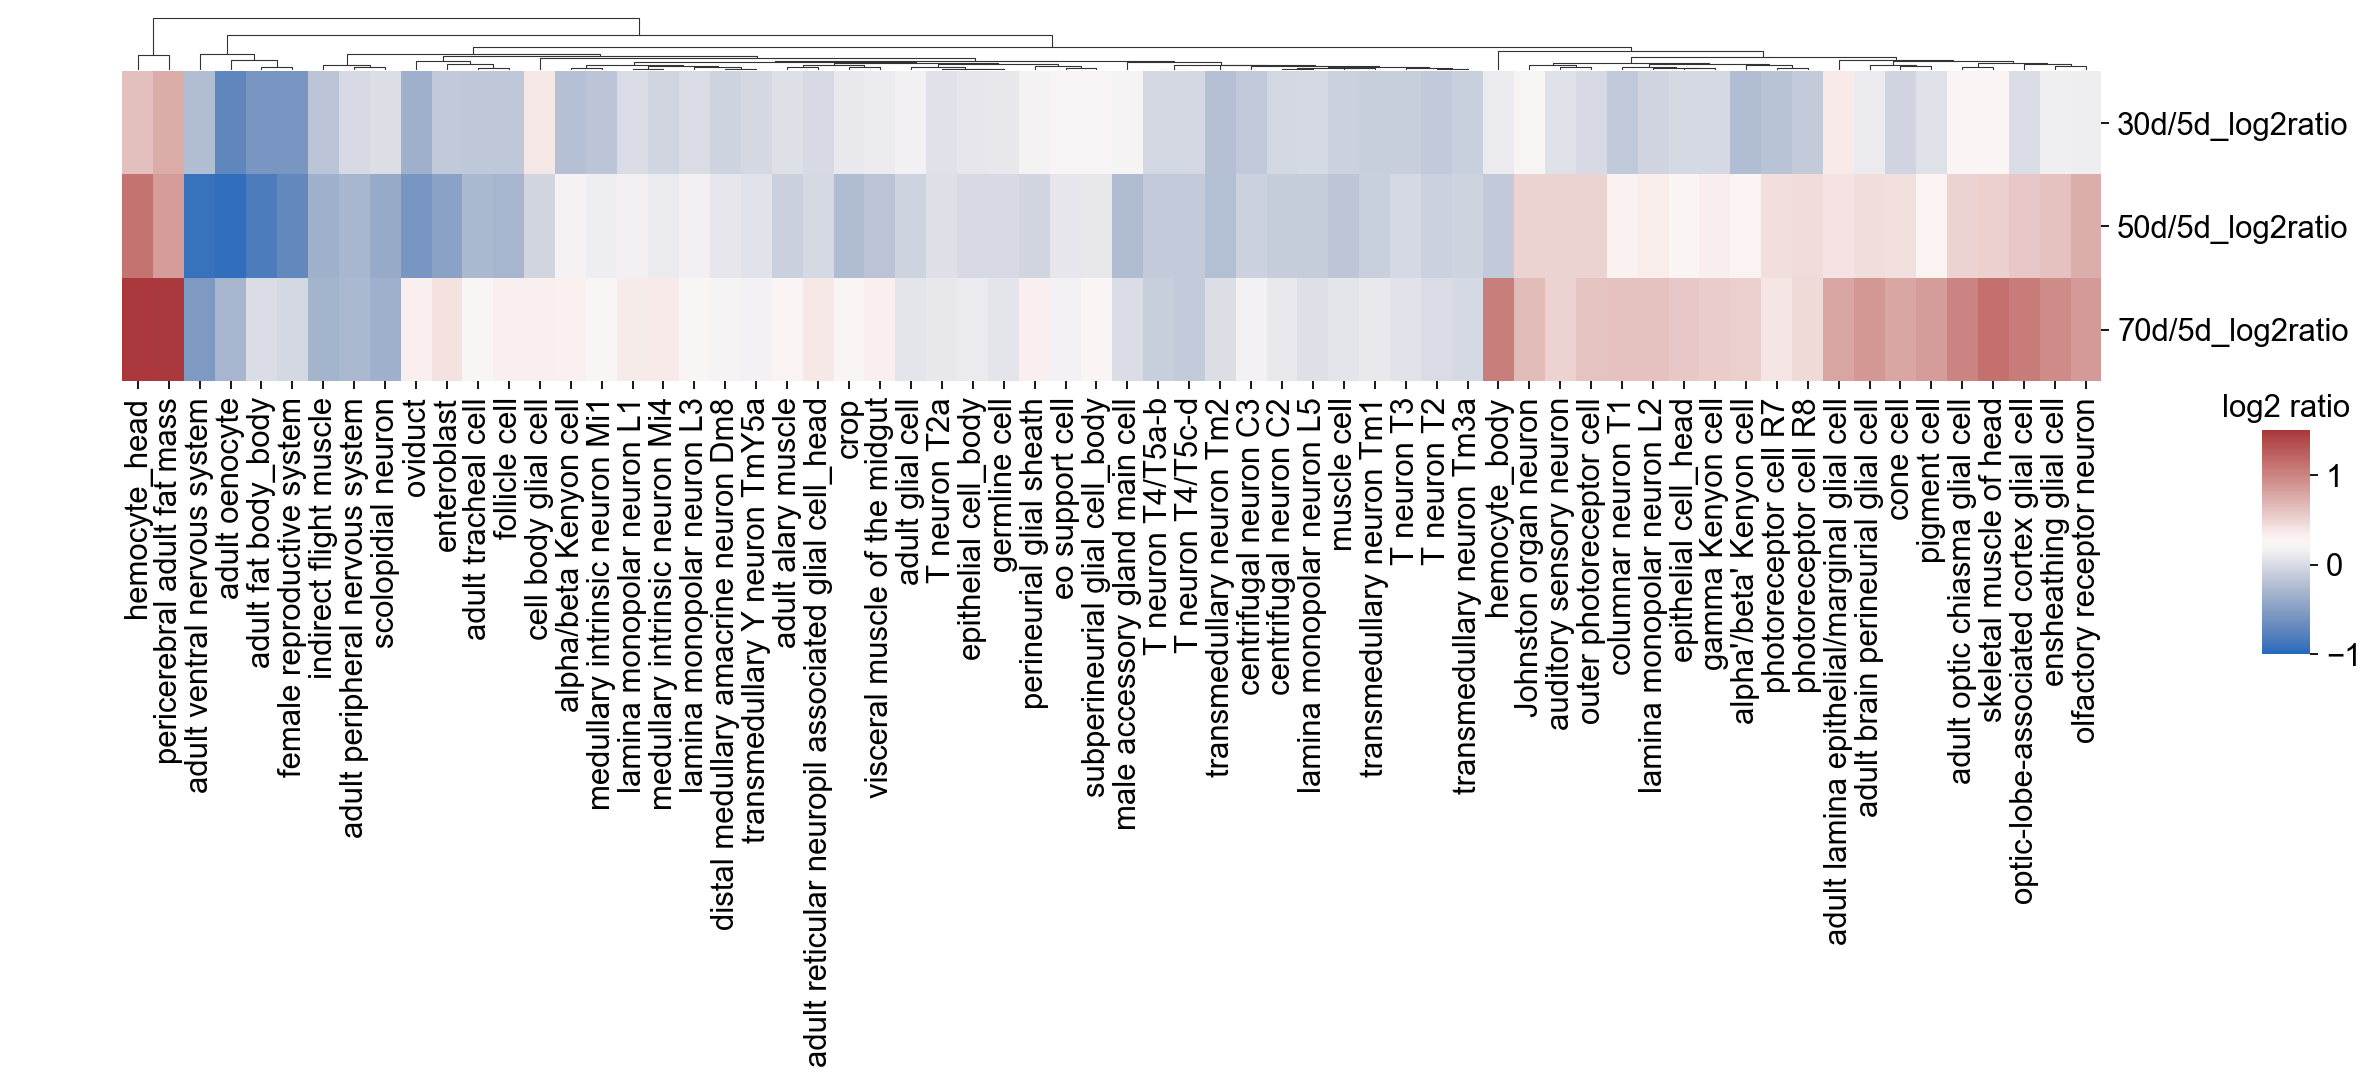

In [37]:
ax=sns.clustermap(umiMedian_mtx_filtered.transpose(), figsize=(15, 7), xticklabels=True, dendrogram_ratio=(0.05, 0.15), 
                  row_cluster=False, cmap="vlag", vmin=-1, vmax=1.5) # standard_scale=1,
plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
ax.ax_cbar.set_position((0.95, .4, .02, .2))
ax.ax_cbar.set_title('log2 ratio')

plt.savefig(f'{figure5PicFolder}/headBody_heatmap_medianUmiRatio_normalizeTo5d.pdf')

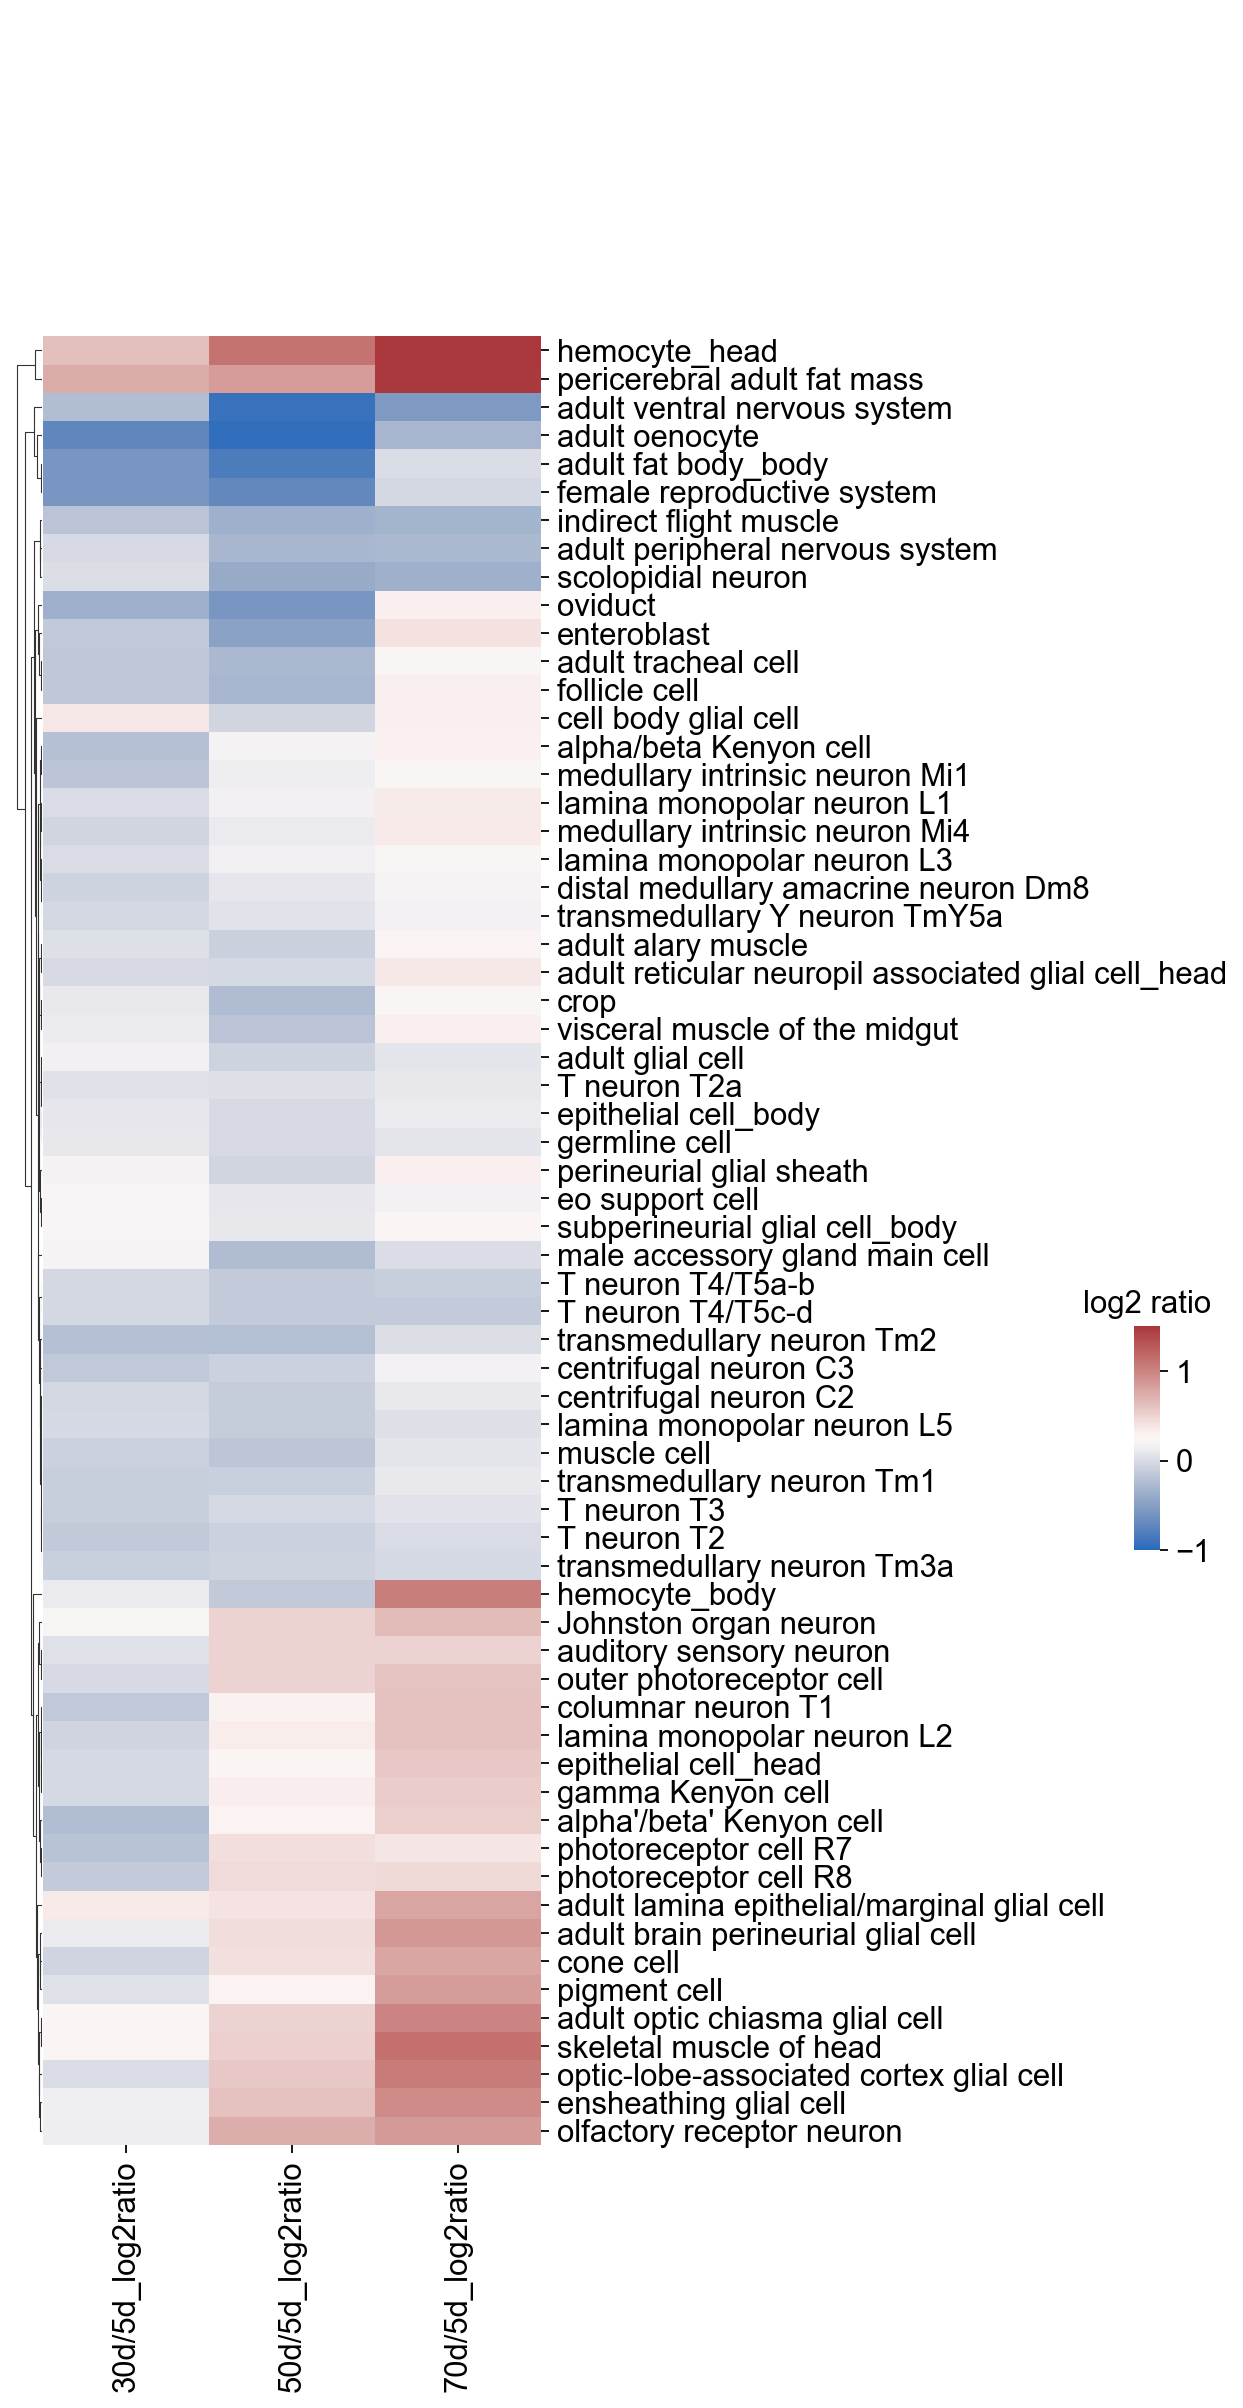

In [38]:
ax=sns.clustermap(umiMedian_mtx_filtered, figsize=(8, 14), yticklabels=True, dendrogram_ratio=(0.05, 0.15), 
                  col_cluster=False, cmap="vlag", vmin=-1, vmax=1.5) # standard_scale=1,
plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
ax.ax_cbar.set_position((0.9, .3, .02, .1))
ax.ax_cbar.set_title('log2 ratio')

plt.savefig(f'{figure5PicFolder}/headBody_heatmap_medianUmiRatio_normalizeTo5d_vertical.pdf')

In [39]:
umiMedian_mtx_select=\
    umiMedian_mtx_filtered[(abs(umiMedian_mtx_filtered['30d/5d_log2ratio']) >= 0.5849625) | 
              (abs(umiMedian_mtx_filtered['50d/5d_log2ratio']) >= 0.5849625)| 
              (abs(umiMedian_mtx_filtered['70d/5d_log2ratio']) >= 0.5849625) ]

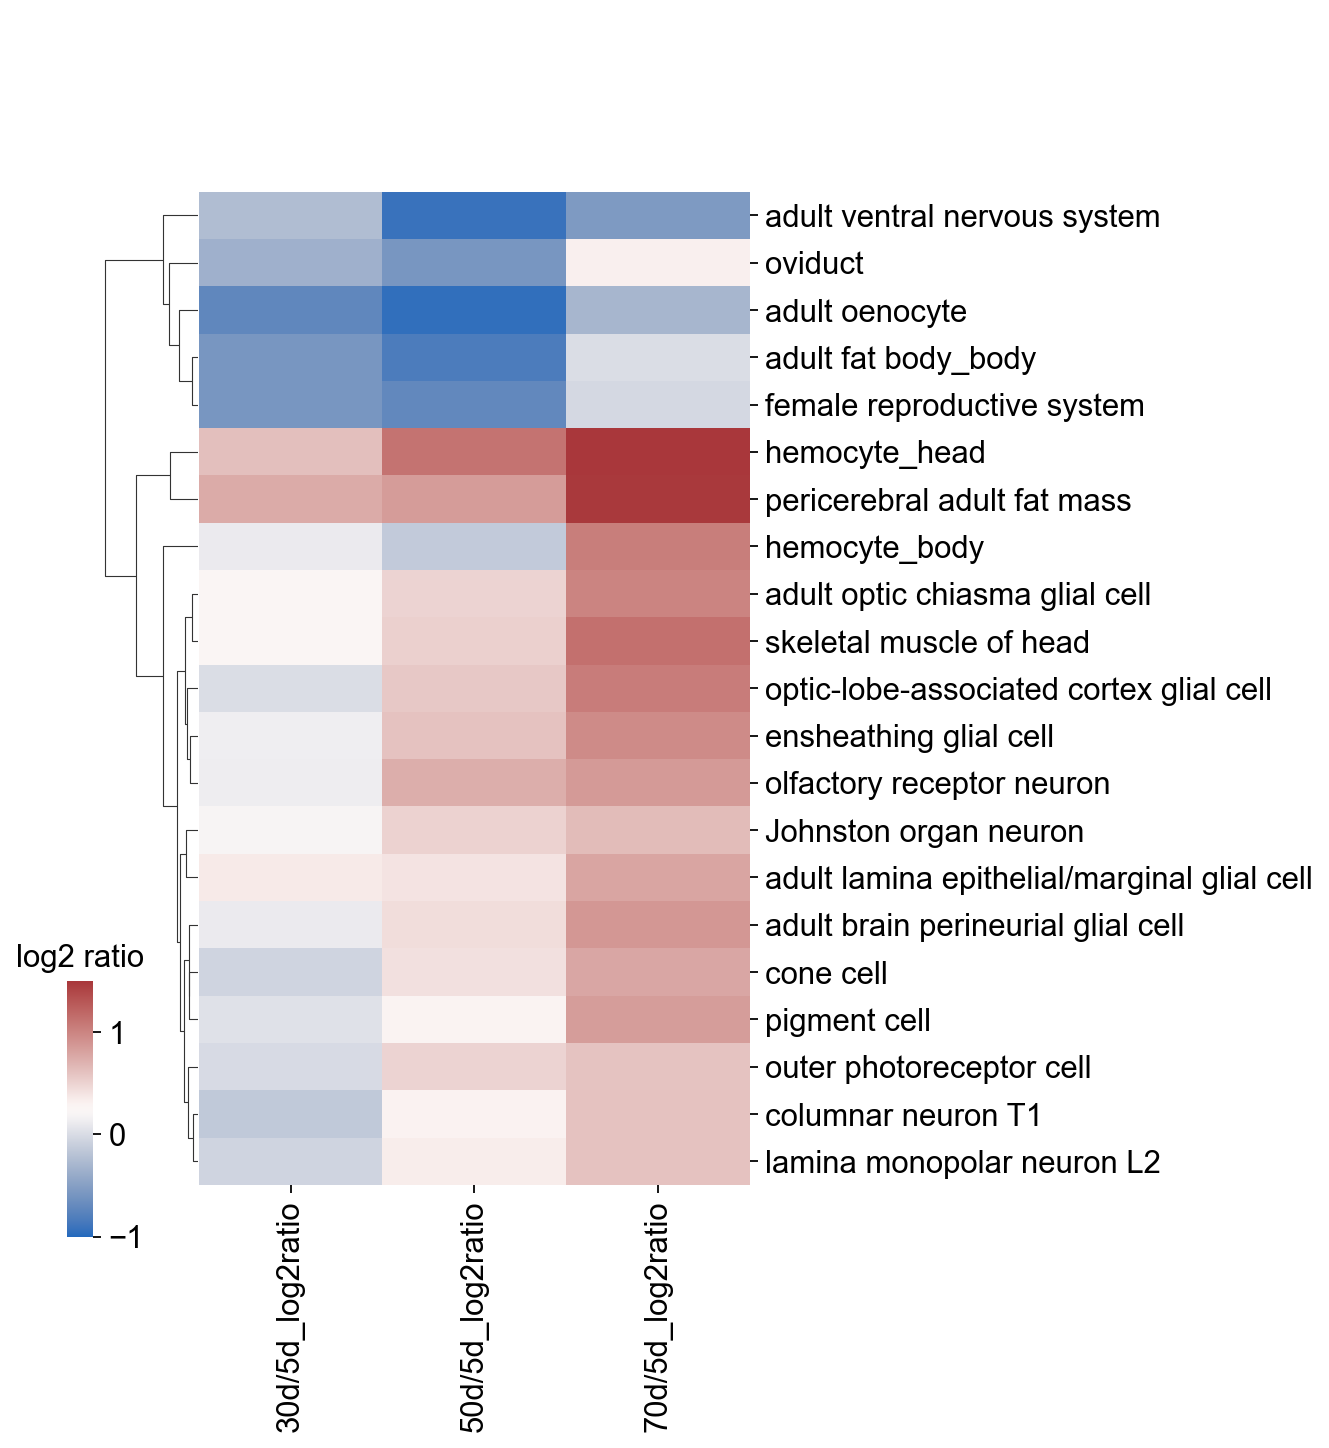

In [40]:
ax=sns.clustermap(umiMedian_mtx_select, figsize=(8, 8), yticklabels=True, dendrogram_ratio=(0.15, 0.15), 
                  col_cluster=False, cmap="vlag", vmin=-1, vmax=1.5) # standard_scale=1,
plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
ax.ax_cbar.set_position((0, .02, .02, .2))
ax.ax_cbar.set_title('log2 ratio')

plt.savefig(f'{figure5PicFolder}/headBody_heatmap_medianUmiRatio_normalizeTo5d_fc1.5.pdf')

In [41]:
print(geneN_Median_mtx_filtered.max())
print(geneN_Median_mtx_filtered.min())

30d/5d_log2ratio    0.395181
50d/5d_log2ratio    0.528664
70d/5d_log2ratio    1.160394
dtype: float64
30d/5d_log2ratio   -0.592620
50d/5d_log2ratio   -0.741369
70d/5d_log2ratio   -0.474307
dtype: float64


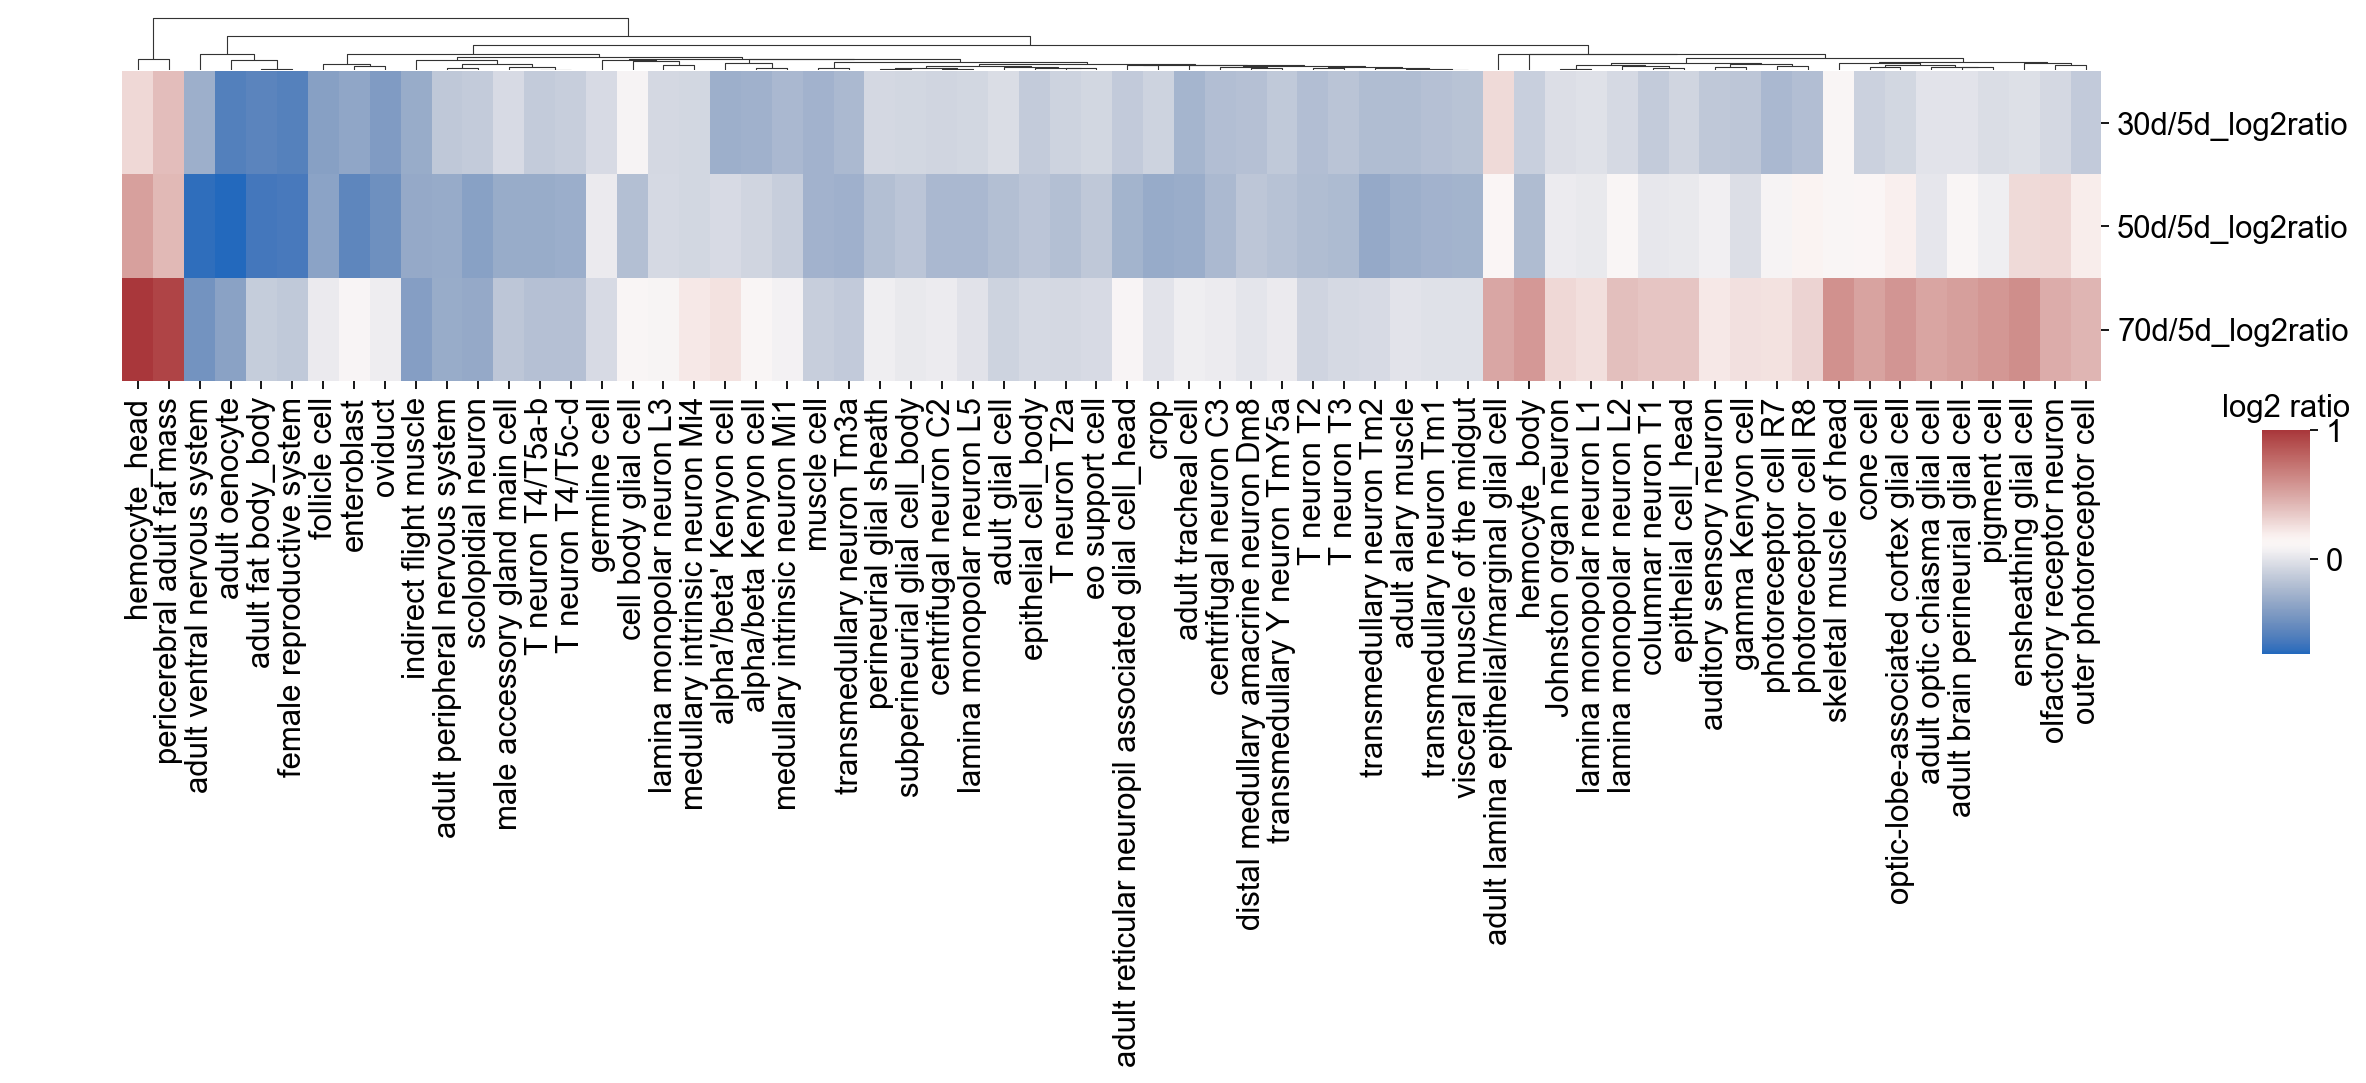

In [42]:
ax=sns.clustermap(geneN_Median_mtx_filtered.transpose(), figsize=(15, 7), xticklabels=True, dendrogram_ratio=(0.05, 0.15), 
                  row_cluster=False, cmap="vlag", vmax=1) # standard_scale=1,
plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
ax.ax_cbar.set_position((0.95, .4, .02, .2))
ax.ax_cbar.set_title('log2 ratio')

plt.savefig(f'{figure5PicFolder}/headBody_heatmap_medianGeneNRatio_normalizeTo5d.pdf')

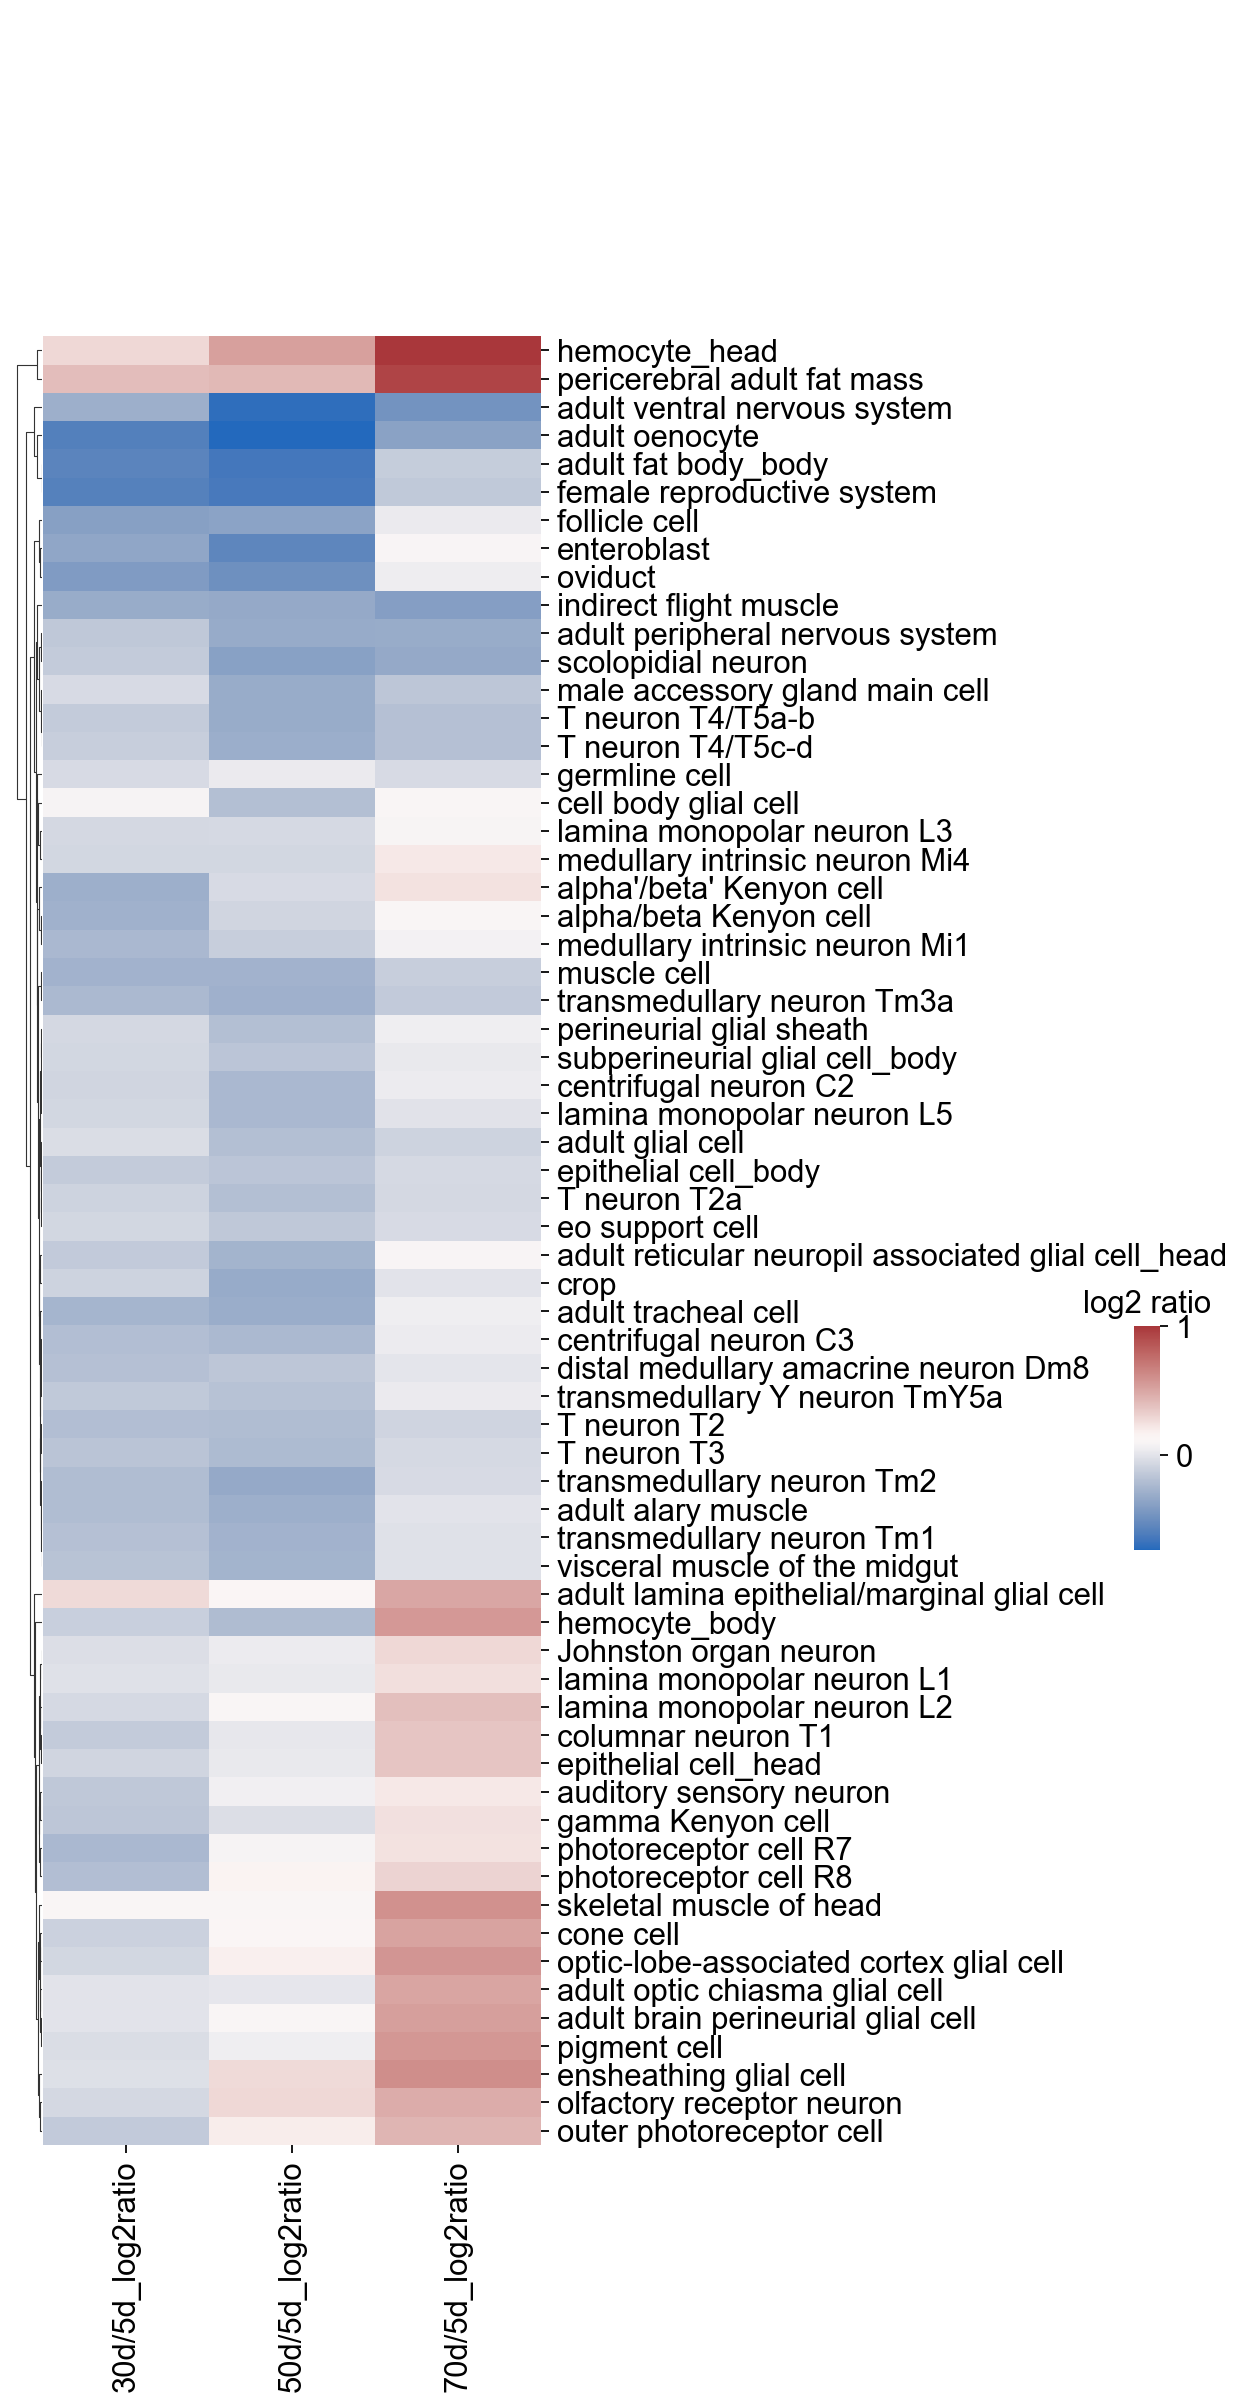

In [43]:
ax=sns.clustermap(geneN_Median_mtx_filtered, figsize=(8, 14), yticklabels=True, dendrogram_ratio=(0.05, 0.15), 
                  col_cluster=False, cmap="vlag", vmax=1) # standard_scale=1,
plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
ax.ax_cbar.set_position((0.9, .3, .02, .1))
ax.ax_cbar.set_title('log2 ratio')

plt.savefig(f'{figure5PicFolder}/headBody_heatmap_medianGeneNRatio_normalizeTo5d_vertical.pdf')

In [44]:
geneN_Median_mtx_select=\
    geneN_Median_mtx_filtered[(abs(geneN_Median_mtx_filtered['30d/5d_log2ratio']) >= 0.5849625) | 
              (abs(geneN_Median_mtx_filtered['50d/5d_log2ratio']) >= 0.5849625)| 
              (abs(geneN_Median_mtx_filtered['70d/5d_log2ratio']) >= 0.5849625) ]

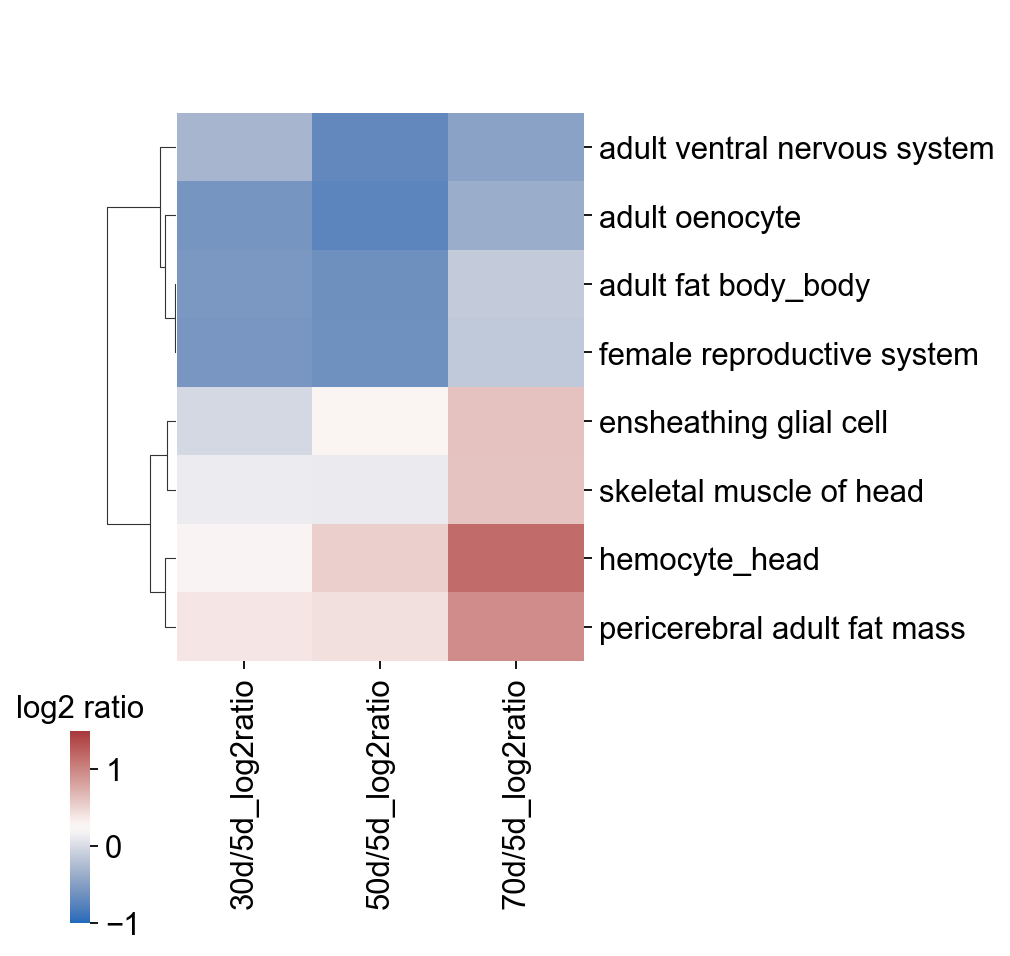

In [45]:
ax=sns.clustermap(geneN_Median_mtx_select, figsize=(6, 6), yticklabels=True, dendrogram_ratio=(0.15, 0.15), 
                  col_cluster=False, cmap="vlag", vmin=-1, vmax=1.5) # standard_scale=1,
plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
ax.ax_cbar.set_position((0, .02, .02, .2))
ax.ax_cbar.set_title('log2 ratio')

plt.savefig(f'{figure5PicFolder}/headBody_heatmap_medianGeneNRatio_normalizeTo5d_fc1.5.pdf')

**Combine UMI/geneN log2 ratio from 50d/5d comparison**

In [46]:
umi_geneN_mtx=umiMedian_mtx_filtered[:]
umi_geneN_mtx.columns = [x.split('_')[0]+'_UMI#' for x in umi_geneN_mtx.columns]
umi_geneN_mtx = pd.concat([umi_geneN_mtx, geneN_Median_mtx_filtered], axis=1)
umi_geneN_mtx.columns = umi_geneN_mtx.columns[:3].to_list()+ [x.split('_')[0]+'_gene#' for x in umi_geneN_mtx.columns[3:]]

umi_geneN_mtx.sort_values(by='50d/5d_UMI#', inplace=True, ascending=False)
umi_geneN_mtx['annotation'] = umi_geneN_mtx.index.to_list()

umi_geneN_mtx

30d/5d_UMI#  50d/5d_UMI#  \
hemocyte_head                               0.627704     1.112911   
pericerebral adult fat mass                 0.755988     0.852392   
olfactory receptor neuron                   0.124696     0.735677   
ensheathing glial cell                      0.136936     0.610412   
optic-lobe-associated cortex glial cell     0.010764     0.572181   
...                                              ...          ...   
oviduct                                    -0.349008    -0.589227   
female reproductive system                 -0.580268    -0.712698   
adult fat body_body                        -0.581128    -0.828570   
adult ventral nervous system               -0.242949    -0.912630   
adult oenocyte                             -0.724735    -0.944398   

                                         70d/5d_UMI#  30d/5d_gene#  \
hemocyte_head                               1.969930      0.281836   
pericerebral adult fat mass                 1.489626      0.395181   
olfactory receptor neuron                   0.865070     -0.066202   
ensheathing glial cell                      0.954532     -0.024722   
optic-lobe-associated cortex glial cell     1.057885     -0.070116   
...                                              ...           ...   
oviduct                                     0.326350     -0.415037   
female reproductive system                 -0.026278     -0.588938   
adult fat body_body                         0.006085     -0.570000   
adult ventral nervous system               -0.543876     -0.297610   
adult oenocyte                             -0.299197     -0.592620   

                                         50d/5d_gene#  70d/5d_gene#  \
hemocyte_head                                0.528664      1.160394   
pericerebral adult fat mass                  0.418666      0.943915   
olfactory receptor neuron                    0.284050      0.470284   
ensheathing glial cell                       0.273501      0.605821   
optic-lobe-associated cortex glial cell      0.182343      0.574890   
...                                               ...           ...   
oviduct                                     -0.495314      0.047546   
female reproductive system                  -0.637518     -0.146983   
adult fat body_body                         -0.647621     -0.125636   
adult ventral nervous system                -0.709878     -0.474307   
adult oenocyte                              -0.741369     -0.378928   

                                                                      annotation  
hemocyte_head                                                      hemocyte_head  
pericerebral adult fat mass                          pericerebral adult fat mass  
olfactory receptor neuron                              olfactory receptor neuron  
ensheathing glial cell                                    ensheathing glial cell  
optic-lobe-associated cortex glial cell  optic-lobe-associated cortex glial cell  
...                                                                          ...  
oviduct                                                                  oviduct  
female reproductive system                            female reproductive system  
adult fat body_body                                          adult fat body_body  
adult ventral nervous system                        adult ventral nervous system  
adult oenocyte                                                    adult oenocyte  

[64 rows x 7 columns]

In [47]:
umi_geneN_mtx_long = umi_geneN_mtx.melt(id_vars=['annotation'], value_vars=umi_geneN_mtx.columns.to_list()[:-1], var_name=['group'], value_name='log2Ratio')
umi_geneN_mtx_long['ageCompare'] = [x.split('_')[0] for x in umi_geneN_mtx_long.group]
umi_geneN_mtx_long['log2Group'] = [x.split('_')[-1] for x in umi_geneN_mtx_long.group]

umi_geneN_mtx_long

annotation         group  log2Ratio  \
0                              hemocyte_head   30d/5d_UMI#   0.627704   
1                pericerebral adult fat mass   30d/5d_UMI#   0.755988   
2                  olfactory receptor neuron   30d/5d_UMI#   0.124696   
3                     ensheathing glial cell   30d/5d_UMI#   0.136936   
4    optic-lobe-associated cortex glial cell   30d/5d_UMI#   0.010764   
..                                       ...           ...        ...   
379                                  oviduct  70d/5d_gene#   0.047546   
380               female reproductive system  70d/5d_gene#  -0.146983   
381                      adult fat body_body  70d/5d_gene#  -0.125636   
382             adult ventral nervous system  70d/5d_gene#  -0.474307   
383                           adult oenocyte  70d/5d_gene#  -0.378928   

    ageCompare log2Group  
0       30d/5d      UMI#  
1       30d/5d      UMI#  
2       30d/5d      UMI#  
3       30d/5d      UMI#  
4       30d/5d      UMI#  
..         ...       ...  
379     70d/5d     gene#  
380     70d/5d     gene#  
381     70d/5d     gene#  
382     70d/5d     gene#  
383     70d/5d     gene#  

[384 rows x 5 columns]

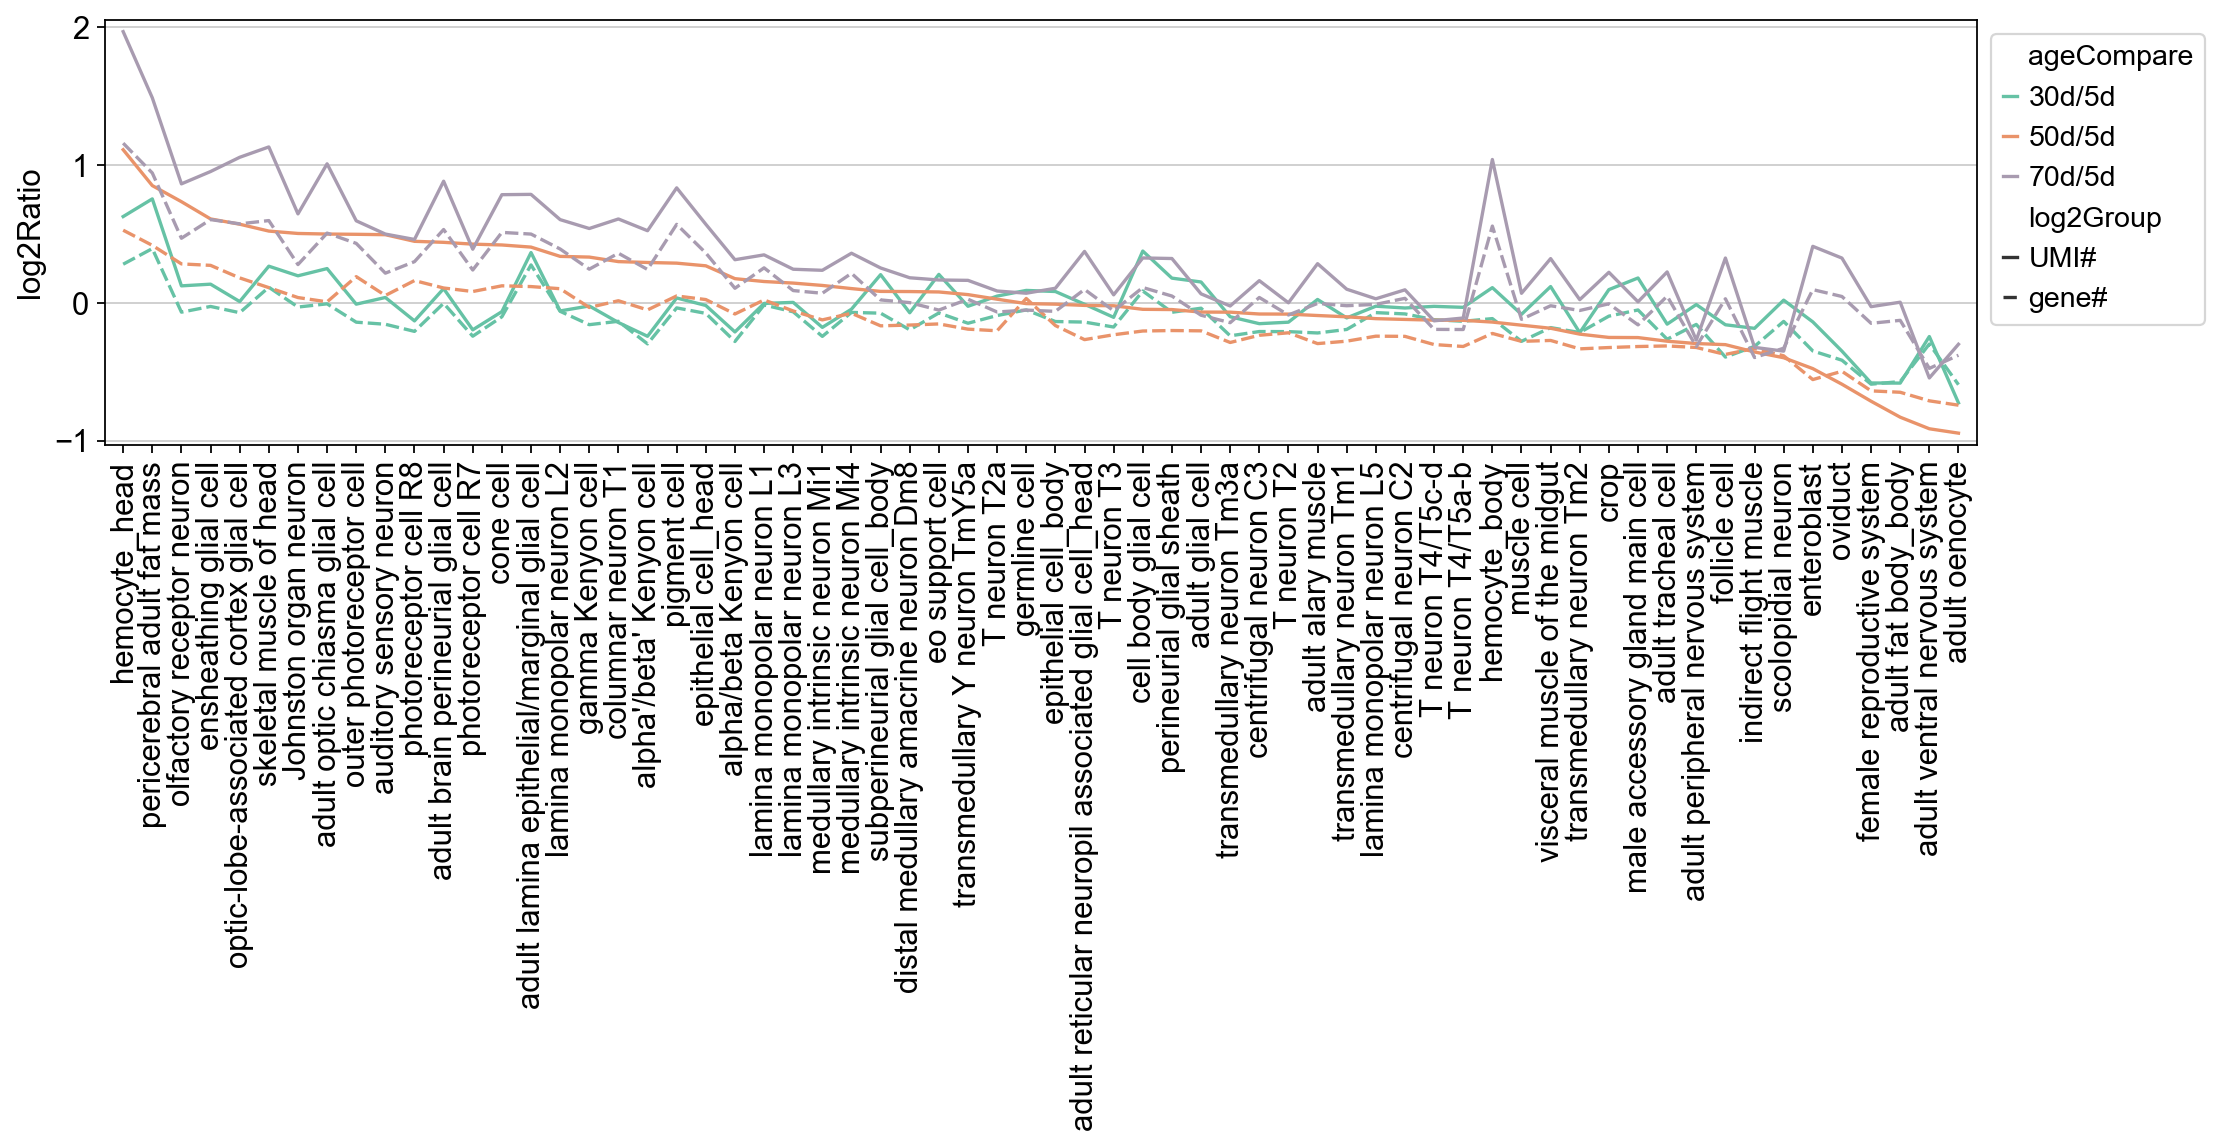

In [48]:
with rc_context({'figure.figsize': (15, 3.5)}):
    fig, ax = plt.subplots()
    
    ax.margins(0.01, 0.03)
    ax.grid(axis='x',visible=False)
    
    sns.lineplot(data=umi_geneN_mtx_long, x='annotation', y='log2Ratio', hue='ageCompare', style='log2Group', palette=set2Color_L)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.xlabel('')
    
    plt.savefig(f'{figure5PicFolder}/log2Ratio_umi_geneN.pdf', bbox_inches='tight')

In [49]:
umi_geneN_mtx.sort_values(by='50d/5d_gene#', inplace=True, ascending=False)
umi_geneN_mtx['annotation'] = umi_geneN_mtx.index.to_list()

umi_geneN_mtx

30d/5d_UMI#  50d/5d_UMI#  70d/5d_UMI#  \
hemocyte_head                    0.627704     1.112911     1.969930   
pericerebral adult fat mass      0.755988     0.852392     1.489626   
olfactory receptor neuron        0.124696     0.735677     0.865070   
ensheathing glial cell           0.136936     0.610412     0.954532   
outer photoreceptor cell        -0.008211     0.498932     0.596922   
...                                   ...          ...          ...   
enteroblast                     -0.136763    -0.475991     0.411535   
female reproductive system      -0.580268    -0.712698    -0.026278   
adult fat body_body             -0.581128    -0.828570     0.006085   
adult ventral nervous system    -0.242949    -0.912630    -0.543876   
adult oenocyte                  -0.724735    -0.944398    -0.299197   

                              30d/5d_gene#  50d/5d_gene#  70d/5d_gene#  \
hemocyte_head                     0.281836      0.528664      1.160394   
pericerebral adult fat mass       0.395181      0.418666      0.943915   
olfactory receptor neuron        -0.066202      0.284050      0.470284   
ensheathing glial cell           -0.024722      0.273501      0.605821   
outer photoreceptor cell         -0.138953      0.191610      0.433036   
...                                    ...           ...           ...   
enteroblast                      -0.347773     -0.555519      0.097441   
female reproductive system       -0.588938     -0.637518     -0.146983   
adult fat body_body              -0.570000     -0.647621     -0.125636   
adult ventral nervous system     -0.297610     -0.709878     -0.474307   
adult oenocyte                   -0.592620     -0.741369     -0.378928   

                                                annotation  
hemocyte_head                                hemocyte_head  
pericerebral adult fat mass    pericerebral adult fat mass  
olfactory receptor neuron        olfactory receptor neuron  
ensheathing glial cell              ensheathing glial cell  
outer photoreceptor cell          outer photoreceptor cell  
...                                                    ...  
enteroblast                                    enteroblast  
female reproductive system      female reproductive system  
adult fat body_body                    adult fat body_body  
adult ventral nervous system  adult ventral nervous system  
adult oenocyte                              adult oenocyte  

[64 rows x 7 columns]

In [50]:
umi_geneN_mtx_long = umi_geneN_mtx.melt(id_vars=['annotation'], value_vars=umi_geneN_mtx.columns.to_list()[:-1], var_name=['group'], value_name='log2Ratio')
umi_geneN_mtx_long['ageCompare'] = [x.split('_')[0] for x in umi_geneN_mtx_long.group]
umi_geneN_mtx_long['log2Group'] = [x.split('_')[-1] for x in umi_geneN_mtx_long.group]

umi_geneN_mtx_long

annotation         group  log2Ratio ageCompare  \
0                   hemocyte_head   30d/5d_UMI#   0.627704     30d/5d   
1     pericerebral adult fat mass   30d/5d_UMI#   0.755988     30d/5d   
2       olfactory receptor neuron   30d/5d_UMI#   0.124696     30d/5d   
3          ensheathing glial cell   30d/5d_UMI#   0.136936     30d/5d   
4        outer photoreceptor cell   30d/5d_UMI#  -0.008211     30d/5d   
..                            ...           ...        ...        ...   
379                   enteroblast  70d/5d_gene#   0.097441     70d/5d   
380    female reproductive system  70d/5d_gene#  -0.146983     70d/5d   
381           adult fat body_body  70d/5d_gene#  -0.125636     70d/5d   
382  adult ventral nervous system  70d/5d_gene#  -0.474307     70d/5d   
383                adult oenocyte  70d/5d_gene#  -0.378928     70d/5d   

    log2Group  
0        UMI#  
1        UMI#  
2        UMI#  
3        UMI#  
4        UMI#  
..        ...  
379     gene#  
380     gene#  
381     gene#  
382     gene#  
383     gene#  

[384 rows x 5 columns]

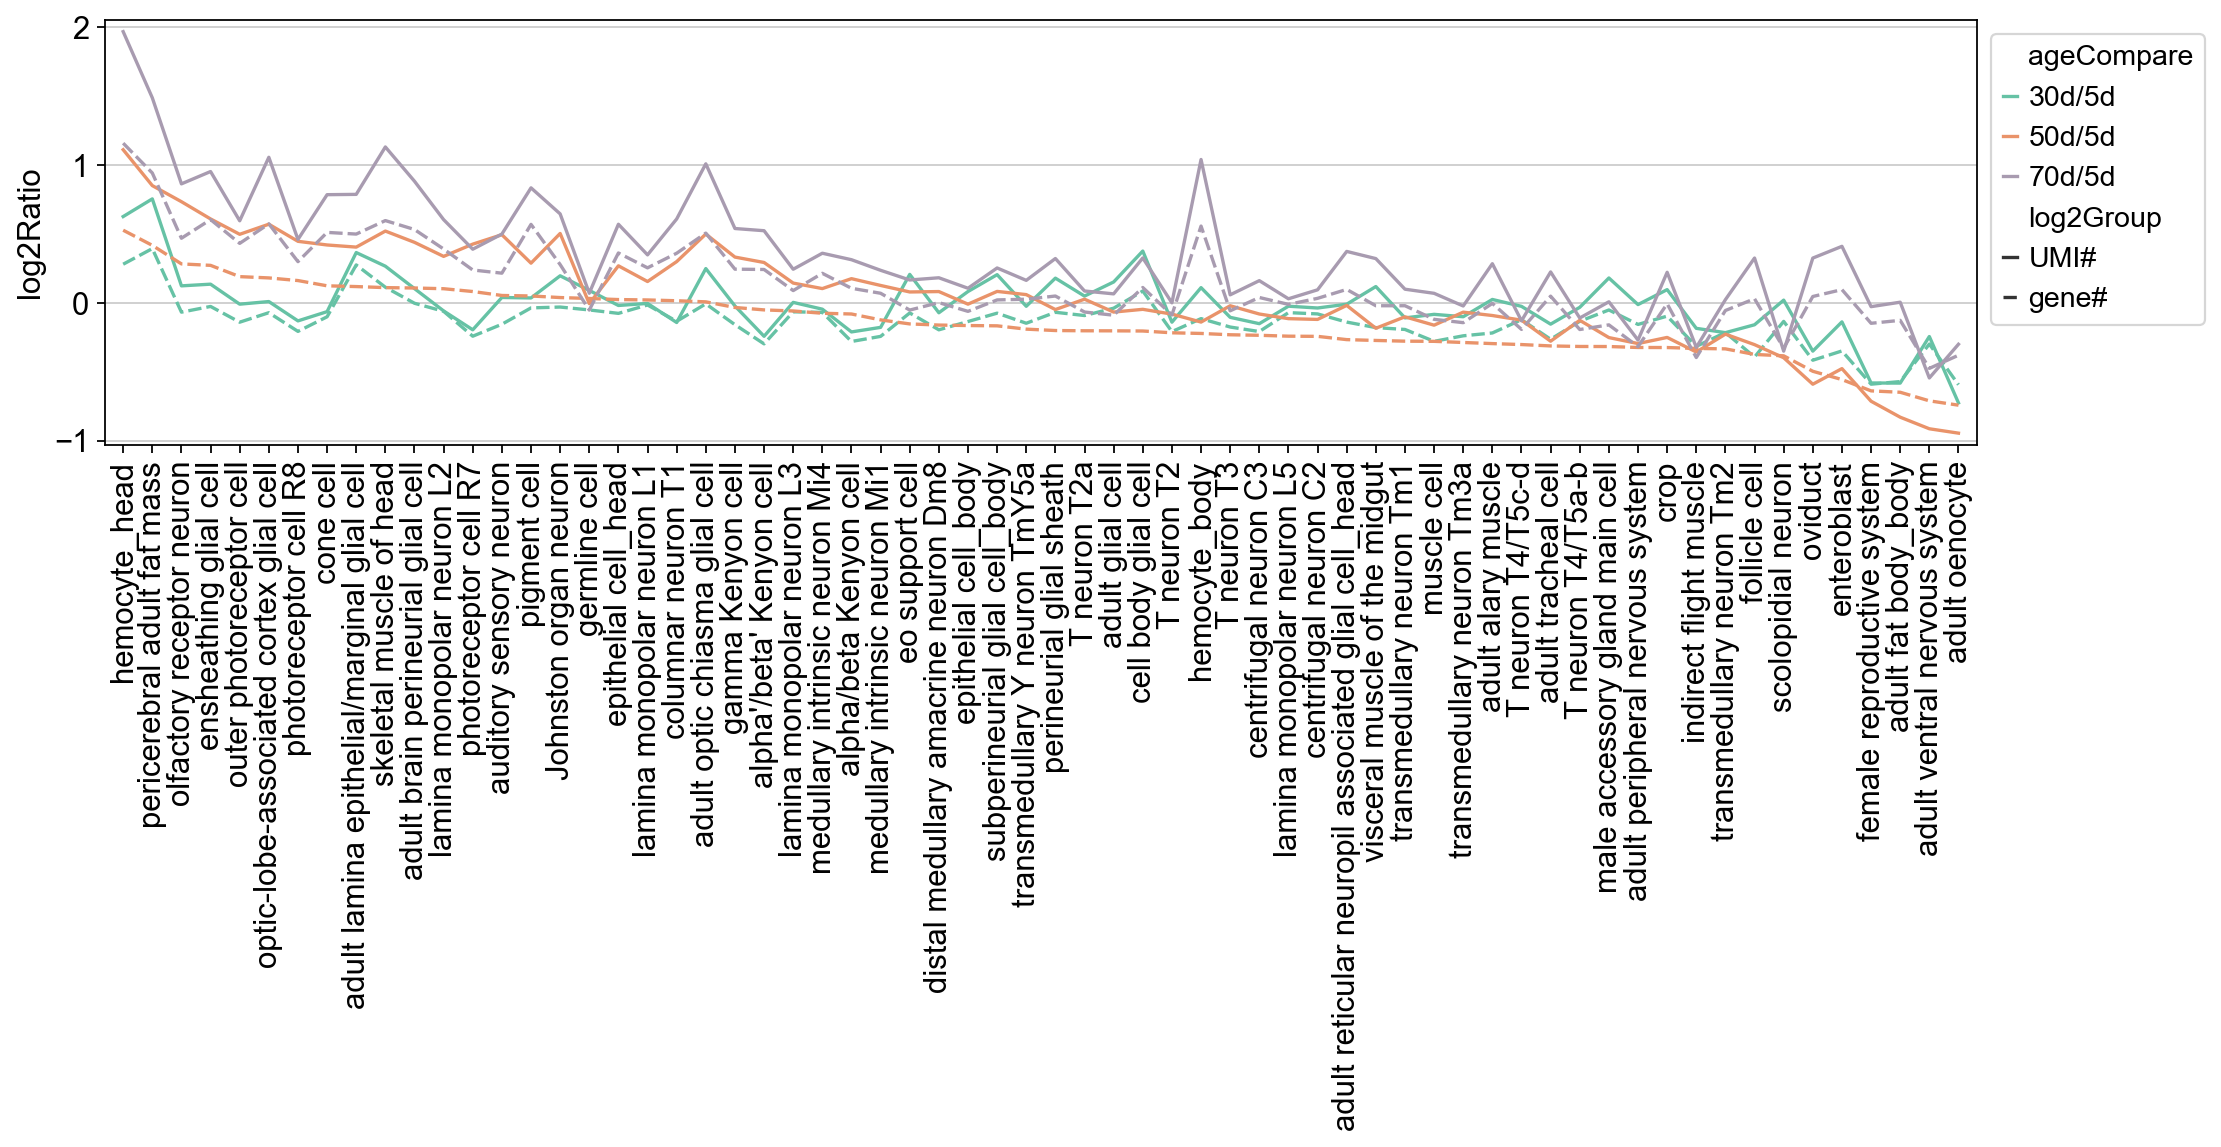

In [51]:
with rc_context({'figure.figsize': (15, 3.5)}):
    fig, ax = plt.subplots()
    
    ax.margins(0.01, 0.03)
    ax.grid(axis='x',visible=False)
    
    sns.lineplot(data=umi_geneN_mtx_long, x='annotation', y='log2Ratio', hue='ageCompare', style='log2Group', palette=set2Color_L)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.xlabel('')
    
    plt.savefig(f'{figure5PicFolder}/log2Ratio_umi_geneN_sortby50d_geneN.pdf', bbox_inches='tight')

**Select FC >= 1.5 (|log2Ratio| >=0.5849625) cell types**

In [52]:
umiMedian_mtx_select=\
    umiMedian_mtx_filtered[(abs(umiMedian_mtx_filtered['30d/5d_log2ratio']) >= 0.5849625) | 
              (abs(umiMedian_mtx_filtered['50d/5d_log2ratio']) >= 0.5849625)| 
              (abs(umiMedian_mtx_filtered['70d/5d_log2ratio']) >= 0.5849625) ]

In [53]:
umiMedian_mtx_select.index

Index(['Johnston organ neuron', 'adult brain perineurial glial cell',
       'adult fat body_body', 'adult lamina epithelial/marginal glial cell',
       'adult oenocyte', 'adult optic chiasma glial cell',
       'adult ventral nervous system', 'columnar neuron T1', 'cone cell',
       'ensheathing glial cell', 'female reproductive system', 'hemocyte_body',
       'hemocyte_head', 'lamina monopolar neuron L2',
       'olfactory receptor neuron', 'optic-lobe-associated cortex glial cell',
       'outer photoreceptor cell', 'oviduct', 'pericerebral adult fat mass',
       'pigment cell', 'skeletal muscle of head'],
      dtype='object')

In [54]:
heatmap_mtx=umi_geneN_mtx[(umi_geneN_mtx.index.isin(umiMedian_mtx_select.index))].iloc[:,:-1]
heatmap_mtx

30d/5d_UMI#  50d/5d_UMI#  \
hemocyte_head                                   0.627704     1.112911   
pericerebral adult fat mass                     0.755988     0.852392   
olfactory receptor neuron                       0.124696     0.735677   
ensheathing glial cell                          0.136936     0.610412   
outer photoreceptor cell                       -0.008211     0.498932   
optic-lobe-associated cortex glial cell         0.010764     0.572181   
cone cell                                      -0.062397     0.421464   
adult lamina epithelial/marginal glial cell     0.366395     0.405960   
skeletal muscle of head                         0.267451     0.522325   
adult brain perineurial glial cell              0.104785     0.440665   
lamina monopolar neuron L2                     -0.057257     0.338671   
pigment cell                                    0.036926     0.289507   
Johnston organ neuron                           0.197740     0.505014   
columnar neuron T1                             -0.141323     0.300682   
adult optic chiasma glial cell                  0.250164     0.500767   
hemocyte_body                                   0.111766    -0.138212   
oviduct                                        -0.349008    -0.589227   
female reproductive system                     -0.580268    -0.712698   
adult fat body_body                            -0.581128    -0.828570   
adult ventral nervous system                   -0.242949    -0.912630   
adult oenocyte                                 -0.724735    -0.944398   

                                             70d/5d_UMI#  30d/5d_gene#  \
hemocyte_head                                   1.969930      0.281836   
pericerebral adult fat mass                     1.489626      0.395181   
olfactory receptor neuron                       0.865070     -0.066202   
ensheathing glial cell                          0.954532     -0.024722   
outer photoreceptor cell                        0.596922     -0.138953   
optic-lobe-associated cortex glial cell         1.057885     -0.070116   
cone cell                                       0.786486     -0.099758   
adult lamina epithelial/marginal glial cell     0.788768      0.276632   
skeletal muscle of head                         1.133016      0.114752   
adult brain perineurial glial cell              0.884158     -0.001576   
lamina monopolar neuron L2                      0.605400     -0.060017   
pigment cell                                    0.836074     -0.035275   
Johnston organ neuron                           0.647119     -0.029088   
columnar neuron T1                              0.610170     -0.132496   
adult optic chiasma glial cell                  1.010593     -0.005806   
hemocyte_body                                   1.041901     -0.112953   
oviduct                                         0.326350     -0.415037   
female reproductive system                     -0.026278     -0.588938   
adult fat body_body                             0.006085     -0.570000   
adult ventral nervous system                   -0.543876     -0.297610   
adult oenocyte                                 -0.299197     -0.592620   

                                             50d/5d_gene#  70d/5d_gene#  
hemocyte_head                                    0.528664      1.160394  
pericerebral adult fat mass                      0.418666      0.943915  
olfactory receptor neuron                        0.284050      0.470284  
ensheathing glial cell                           0.273501      0.605821  
outer photoreceptor cell                         0.191610      0.433036  
optic-lobe-associated cortex glial cell          0.182343      0.574890  
cone cell                                        0.125013      0.512706  
adult lamina epithelial/marginal glial cell      0.119507      0.500570  
skeletal muscle of head                          0.111846      0.598519  
adult brain perineurial glial cell               0.109163      0.5336

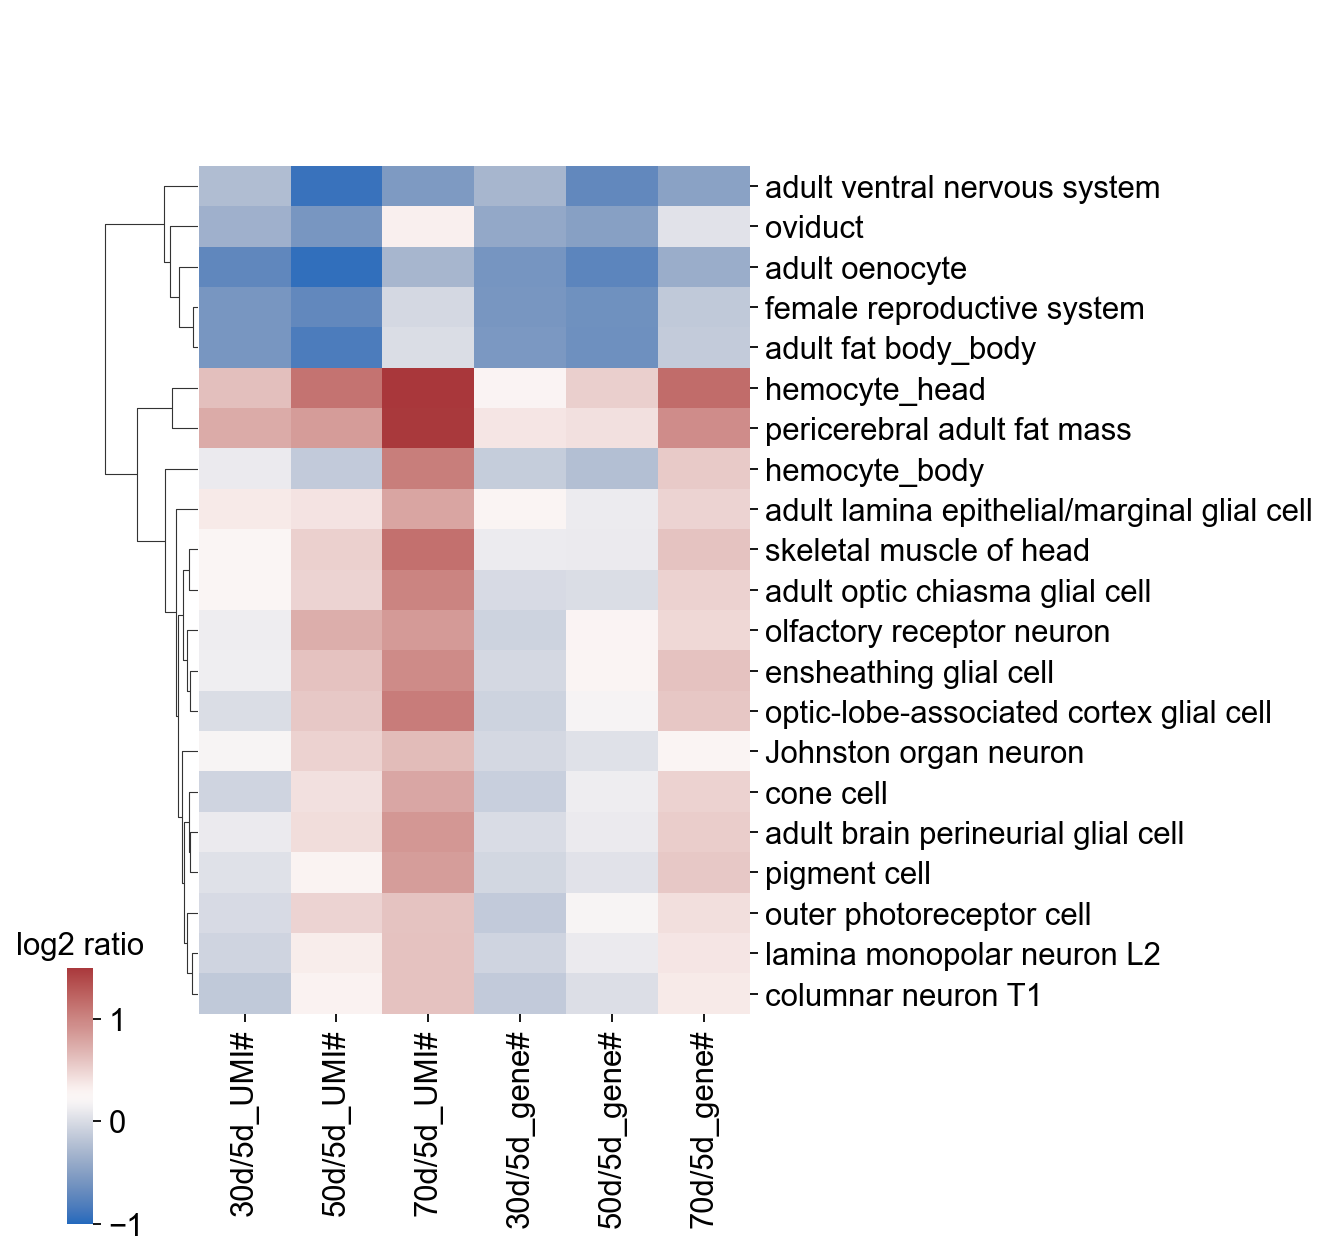

In [55]:
ax=sns.clustermap(heatmap_mtx, figsize=(8, 8), yticklabels=True, dendrogram_ratio=(0.15, 0.15), 
                  col_cluster=False, cmap="vlag", vmin=-1, vmax=1.5) # standard_scale=1,
plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
ax.ax_cbar.set_position((0, .03, .02, .2))
ax.ax_cbar.set_title('log2 ratio')

plt.savefig(f'{figure5PicFolder}/headBody_heatmap_medianUmiGeneNRatio_normalizeTo5d_fc1.5.pdf')

In [56]:
stat_Df = pd.DataFrame(columns=['annotation', 'countType', 'ageCompare', 
                                'ranksumsTwoSides_stat', 'ranksumsTwoSides_pvalue', 
                                'ranksumsGreater_stat', 'ranksumsGreater_pvalue', 
                                'ranksumsLess_stat', 'ranksumsLess_pvalue'])

for cellType in heatmap_mtx.index[:]:
    print(cellType)
    
    for countType in ['total_counts', 'n_genes_by_counts']:
        adata=adata_headBody[ (adata_headBody.obs.afca_annotation == cellType) ]
        count5d_L=adata[adata.obs.age == age_L[0]].obs[countType].to_list()
        
        for i, age in enumerate(age_L[:-1]):
            ageCompare=f'{age_L[0]}d/{age_L[i+1]}d'
            
            countAge_L=adata[adata.obs.age == age_L[i+1]].obs[countType].to_list()
            
            # Stat
            ranksumsTwosides=ranksums(count5d_L, countAge_L)
            ranksumsGreater=ranksums(count5d_L, countAge_L, alternative='greater')
            ranksumsLess=ranksums(count5d_L, countAge_L, alternative='less')
            
            ranksumsTwosides
            
            out_L=[cellType, countType, ageCompare, 
                   ranksumsTwosides.statistic, ranksumsTwosides.pvalue, 
                   ranksumsGreater.statistic, ranksumsGreater.pvalue,
                   ranksumsLess.statistic, ranksumsLess.pvalue]
            stat_Df=pd.concat([ stat_Df, pd.DataFrame([out_L], columns=stat_Df.columns.to_list()) ])
stat_Df

hemocyte_head
pericerebral adult fat mass
olfactory receptor neuron
ensheathing glial cell
outer photoreceptor cell
optic-lobe-associated cortex glial cell
cone cell
adult lamina epithelial/marginal glial cell
skeletal muscle of head
adult brain perineurial glial cell
lamina monopolar neuron L2
pigment cell
Johnston organ neuron
columnar neuron T1
adult optic chiasma glial cell
hemocyte_body
oviduct
female reproductive system
adult fat body_body
adult ventral nervous system
adult oenocyte


annotation          countType ageCompare  ranksumsTwoSides_stat  \
0    hemocyte_head       total_counts     5d/30d              -5.122220   
0    hemocyte_head       total_counts     5d/50d              -9.639578   
0    hemocyte_head       total_counts     5d/70d             -14.294876   
0    hemocyte_head  n_genes_by_counts     5d/30d              -2.771804   
0    hemocyte_head  n_genes_by_counts     5d/50d              -5.942974   
..             ...                ...        ...                    ...   
0   adult oenocyte       total_counts     5d/50d              29.831990   
0   adult oenocyte       total_counts     5d/70d              11.582472   
0   adult oenocyte  n_genes_by_counts     5d/30d              31.598994   
0   adult oenocyte  n_genes_by_counts     5d/50d              33.585037   
0   adult oenocyte  n_genes_by_counts     5d/70d              22.305978   

    ranksumsTwoSides_pvalue  ranksumsGreater_stat  ranksumsGreater_pvalue  \
0              3.019587e-07             -5.122220            9.999998e-01   
0              5.441114e-22             -9.639578            1.000000e+00   
0              2.355248e-46            -14.294876            1.000000e+00   
0              5.574660e-03             -2.771804            9.972127e-01   
0              2.798975e-09             -5.942974            1.000000e+00   
..                      ...                   ...                     ...   
0             1.503488e-195             29.831990           7.517438e-196   
0              5.056625e-31             11.582472            2.528312e-31   
0             3.811399e-219             31.598994           1.905700e-219   
0             2.774325e-247             33.585037           1.387163e-247   
0             3.232946e-110             22.305978           1.616473e-110   

    ranksumsLess_stat  ranksumsLess_pvalue  
0           -5.122220         1.509793e-07  
0           -9.639578         2.720557e-22  
0          -14.294876         1.177624e-46  
0           -2.771804         2.787330e-03  
0           -5.942974         1.399487e-09  
..                ...                  ...  
0           29.831990         1.000000e+00  
0           11.582472         1.000000e+00  
0           31.598994         1.000000e+00  
0           33.585037         1.000000e+00  
0           22.305978         1.000000e+00  

[126 rows x 9 columns]

In [57]:
stat_Df[stat_Df.ranksumsTwoSides_pvalue > 0.05]

annotation          countType ageCompare  \
0  optic-lobe-associated cortex glial cell       total_counts     5d/30d   
0               lamina monopolar neuron L2       total_counts     5d/30d   
0               lamina monopolar neuron L2  n_genes_by_counts     5d/30d   
0                             pigment cell       total_counts     5d/30d   
0                    Johnston organ neuron  n_genes_by_counts     5d/50d   
0                       columnar neuron T1  n_genes_by_counts     5d/50d   
0           adult optic chiasma glial cell  n_genes_by_counts     5d/30d   
0           adult optic chiasma glial cell  n_genes_by_counts     5d/50d   
0                            hemocyte_body       total_counts     5d/50d   
0                                  oviduct  n_genes_by_counts     5d/70d   
0               female reproductive system       total_counts     5d/70d   

   ranksumsTwoSides_stat  ranksumsTwoSides_pvalue  ranksumsGreater_stat  \
0              -0.137883                 0.890333             -0.137883   
0               0.411390                 0.680787              0.411390   
0               1.239419                 0.215190              1.239419   
0              -1.292078                 0.196330             -1.292078   
0              -0.655103                 0.512402             -0.655103   
0               1.659584                 0.096998              1.659584   
0               1.165749                 0.243716              1.165749   
0               0.646357                 0.518048              0.646357   
0               1.714462                 0.086444              1.714462   
0              -0.543330                 0.586903             -0.543330   
0              -0.303246                 0.761702             -0.303246   

   ranksumsGreater_pvalue  ranksumsLess_stat  ranksumsLess_pvalue  
0                0.554833          -0.137883             0.445167  
0                0.340393           0.411390             0.659607  
0                0.107595           1.239419             0.892405  
0                0.901835          -1.292078             0.098165  
0                0.743799          -0.655103             0.256201  
0                0.048499           1.659584             0.951501  
0                0.121858           1.165749             0.878142  
0                0.259024           0.646357             0.740976  
0                0.043222           1.714462             0.956778  
0                0.706549          -0.543330             0.293451  
0                0.619149          -0.303246             0.380851

In [58]:
stat_Df.to_csv(f'{figure5Folder}/umi_geneN_ranksumsTest.csv', index=False)

**Highlight 50d/5d**

In [59]:
celltypeN500_L = pd.read_csv(f'{figure2DataFolder}/cellN/celltype_cellN_n500.csv').annotation.to_list()

In [60]:
cellTypeOrder_L=[x.strip() for x in open(f'{figureDataFolder}/agingFeature_cellTypeName_modified.list')]
cellTypeOrderSelected_L=[x.strip() for x in open(f'{figureDataFolder}/agingFeature_cellTypeName_modified_selected.list')]

In [61]:
normalRatio_Df=pd.read_csv(f'{figure2DataFolder}/cellN/headBody_normalRatioDf_normalizeTo5d.csv', index_col=0).iloc[:,1:]
normalRatio_Df

annotation  \
cardia (1)                                                                                 cardia (1)   
adult fat body_body                                                               adult fat body_body   
male accessory gland main cell                                         male accessory gland main cell   
enteroblast                                                                               enteroblast   
adult salivary gland                                                             adult salivary gland   
...                                                                                               ...   
visceral muscle of the crop                                               visceral muscle of the crop   
muscle cell                                                                               muscle cell   
germline cell                                                                           germline cell   
adult reticular neuropil associated glial cell_...  adult reticular neuropil associated glial cell...   
indirect flight muscle                                                         indirect flight muscle   

                                                    30d/5d_ratio  \
cardia (1)                                              3.366614   
adult fat body_body                                     2.441033   
male accessory gland main cell                          2.174354   
enteroblast                                             1.664538   
adult salivary gland                                    2.402504   
...                                                          ...   
visceral muscle of the crop                            -0.803392   
muscle cell                                            -0.766909   
germline cell                                          -2.107656   
adult reticular neuropil associated glial cell_...      1.084027   
indirect flight muscle                                  0.616862   

                                                    50d/5d_ratio  \
cardia (1)                                              3.970931   
adult fat body_body                                     2.784070   
male accessory gland main cell                          2.545936   
enteroblast                                             2.471348   
adult salivary gland                                    2.364433   
...                                                          ...   
visceral muscle of the crop                            -1.091072   
muscle cell                                            -1.220535   
germline cell                                          -1.261042   
adult reticular neuropil associated glial cell_...     -1.350827   
indirect flight muscle                                 -2.085490   

                                                    70d/5d_ratio tissue  
cardia (1)                                              3.720461   body  
adult fat body_body                                     2.185617   body  
male accessory gland main cell                          0.900669   body  
enteroblast                                             2.500458   body  
adult salivary gland                                    2.241751   body  
...                                                          ...    ...  
visceral muscle of the crop                            -1.644615   body  
muscle cell                                            -1.249407   body  
germline cell                                          -0.698137   body  
adult reticular neuropil associated glial cell_...     -0.445817   body  
indirect flight muscle                                 -2.050574   body  

[112 rows x 5 columns]

In [62]:
umi_geneN_mtx=pd.DataFrame({'50d/5d_UMI#': umiMedian_mtx_filtered['50d/5d_log2ratio']})
umi_geneN_mtx['50d/5d_gene#'] = geneN_Median_mtx_filtered['50d/5d_log2ratio']
umi_geneN_mtx.sort_values(by='50d/5d_UMI#', inplace=True, ascending=False)
umi_geneN_mtx['annotation'] = umi_geneN_mtx.index.to_list()
umi_geneN_mtx

50d/5d_UMI#  50d/5d_gene#  \
hemocyte_head                               1.112911      0.528664   
pericerebral adult fat mass                 0.852392      0.418666   
olfactory receptor neuron                   0.735677      0.284050   
ensheathing glial cell                      0.610412      0.273501   
optic-lobe-associated cortex glial cell     0.572181      0.182343   
...                                              ...           ...   
oviduct                                    -0.589227     -0.495314   
female reproductive system                 -0.712698     -0.637518   
adult fat body_body                        -0.828570     -0.647621   
adult ventral nervous system               -0.912630     -0.709878   
adult oenocyte                             -0.944398     -0.741369   

                                                                      annotation  
hemocyte_head                                                      hemocyte_head  
pericerebral adult fat mass                          pericerebral adult fat mass  
olfactory receptor neuron                              olfactory receptor neuron  
ensheathing glial cell                                    ensheathing glial cell  
optic-lobe-associated cortex glial cell  optic-lobe-associated cortex glial cell  
...                                                                          ...  
oviduct                                                                  oviduct  
female reproductive system                            female reproductive system  
adult fat body_body                                          adult fat body_body  
adult ventral nervous system                        adult ventral nervous system  
adult oenocyte                                                    adult oenocyte  

[64 rows x 3 columns]

In [63]:
umi_geneN_mtx_long = umi_geneN_mtx.melt(id_vars=['annotation'], value_vars=['50d/5d_UMI#', '50d/5d_gene#'], var_name=['group'], value_name='log2Ratio')
umi_geneN_mtx_long['dot']='o'
umi_geneN_mtx_long

annotation         group  log2Ratio dot
0                              hemocyte_head   50d/5d_UMI#   1.112911   o
1                pericerebral adult fat mass   50d/5d_UMI#   0.852392   o
2                  olfactory receptor neuron   50d/5d_UMI#   0.735677   o
3                     ensheathing glial cell   50d/5d_UMI#   0.610412   o
4    optic-lobe-associated cortex glial cell   50d/5d_UMI#   0.572181   o
..                                       ...           ...        ...  ..
123                                  oviduct  50d/5d_gene#  -0.495314   o
124               female reproductive system  50d/5d_gene#  -0.637518   o
125                      adult fat body_body  50d/5d_gene#  -0.647621   o
126             adult ventral nervous system  50d/5d_gene#  -0.709878   o
127                           adult oenocyte  50d/5d_gene#  -0.741369   o

[128 rows x 4 columns]

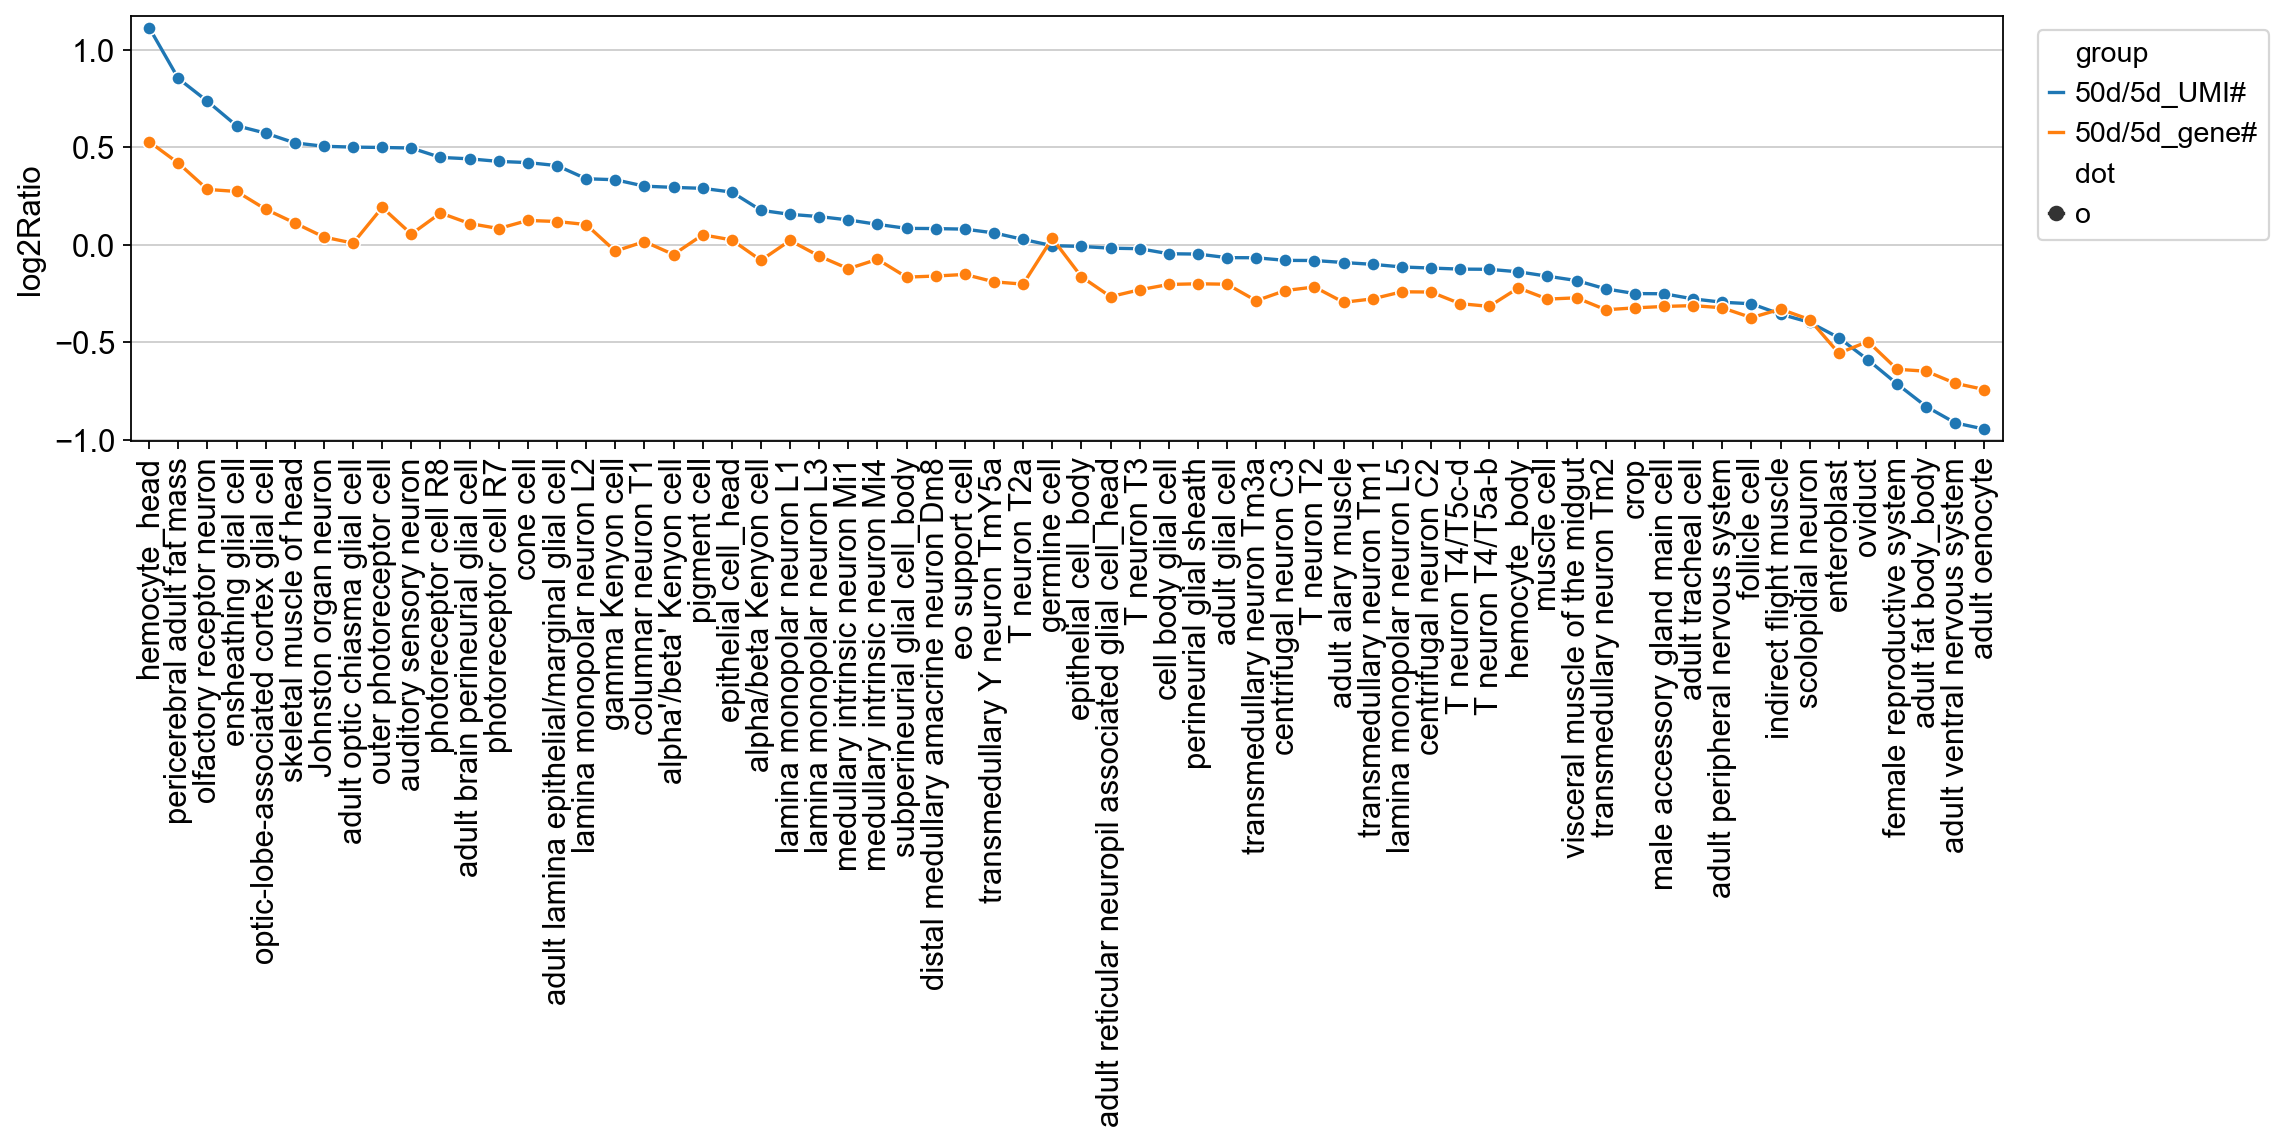

In [64]:
with rc_context({'figure.figsize': (15, 3.5)}):
    fig, ax = plt.subplots()
    
    ax.margins(0.01, 0.03)
    ax.grid(axis='x',visible=False)
    
    sns.lineplot(data=umi_geneN_mtx_long, x='annotation', y='log2Ratio', hue='group', markers=True, style='dot')
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.legend(bbox_to_anchor=(1.15, 1.0))
    
    plt.savefig(f'{figure5PicFolder}/log2Ratio_umi_geneN_50to5.pdf', bbox_inches='tight')

In [65]:
umi_geneN_mtx.sort_values(by='50d/5d_gene#', inplace=True, ascending=False)

In [66]:
umi_geneN_mtx_long = umi_geneN_mtx.melt(id_vars=['annotation'], value_vars=['50d/5d_UMI#', '50d/5d_gene#'], var_name=['group'], value_name='log2Ratio')
umi_geneN_mtx_long['dot']='o'
umi_geneN_mtx_long

annotation         group  log2Ratio dot
0                   hemocyte_head   50d/5d_UMI#   1.112911   o
1     pericerebral adult fat mass   50d/5d_UMI#   0.852392   o
2       olfactory receptor neuron   50d/5d_UMI#   0.735677   o
3          ensheathing glial cell   50d/5d_UMI#   0.610412   o
4        outer photoreceptor cell   50d/5d_UMI#   0.498932   o
..                            ...           ...        ...  ..
123                   enteroblast  50d/5d_gene#  -0.555519   o
124    female reproductive system  50d/5d_gene#  -0.637518   o
125           adult fat body_body  50d/5d_gene#  -0.647621   o
126  adult ventral nervous system  50d/5d_gene#  -0.709878   o
127                adult oenocyte  50d/5d_gene#  -0.741369   o

[128 rows x 4 columns]

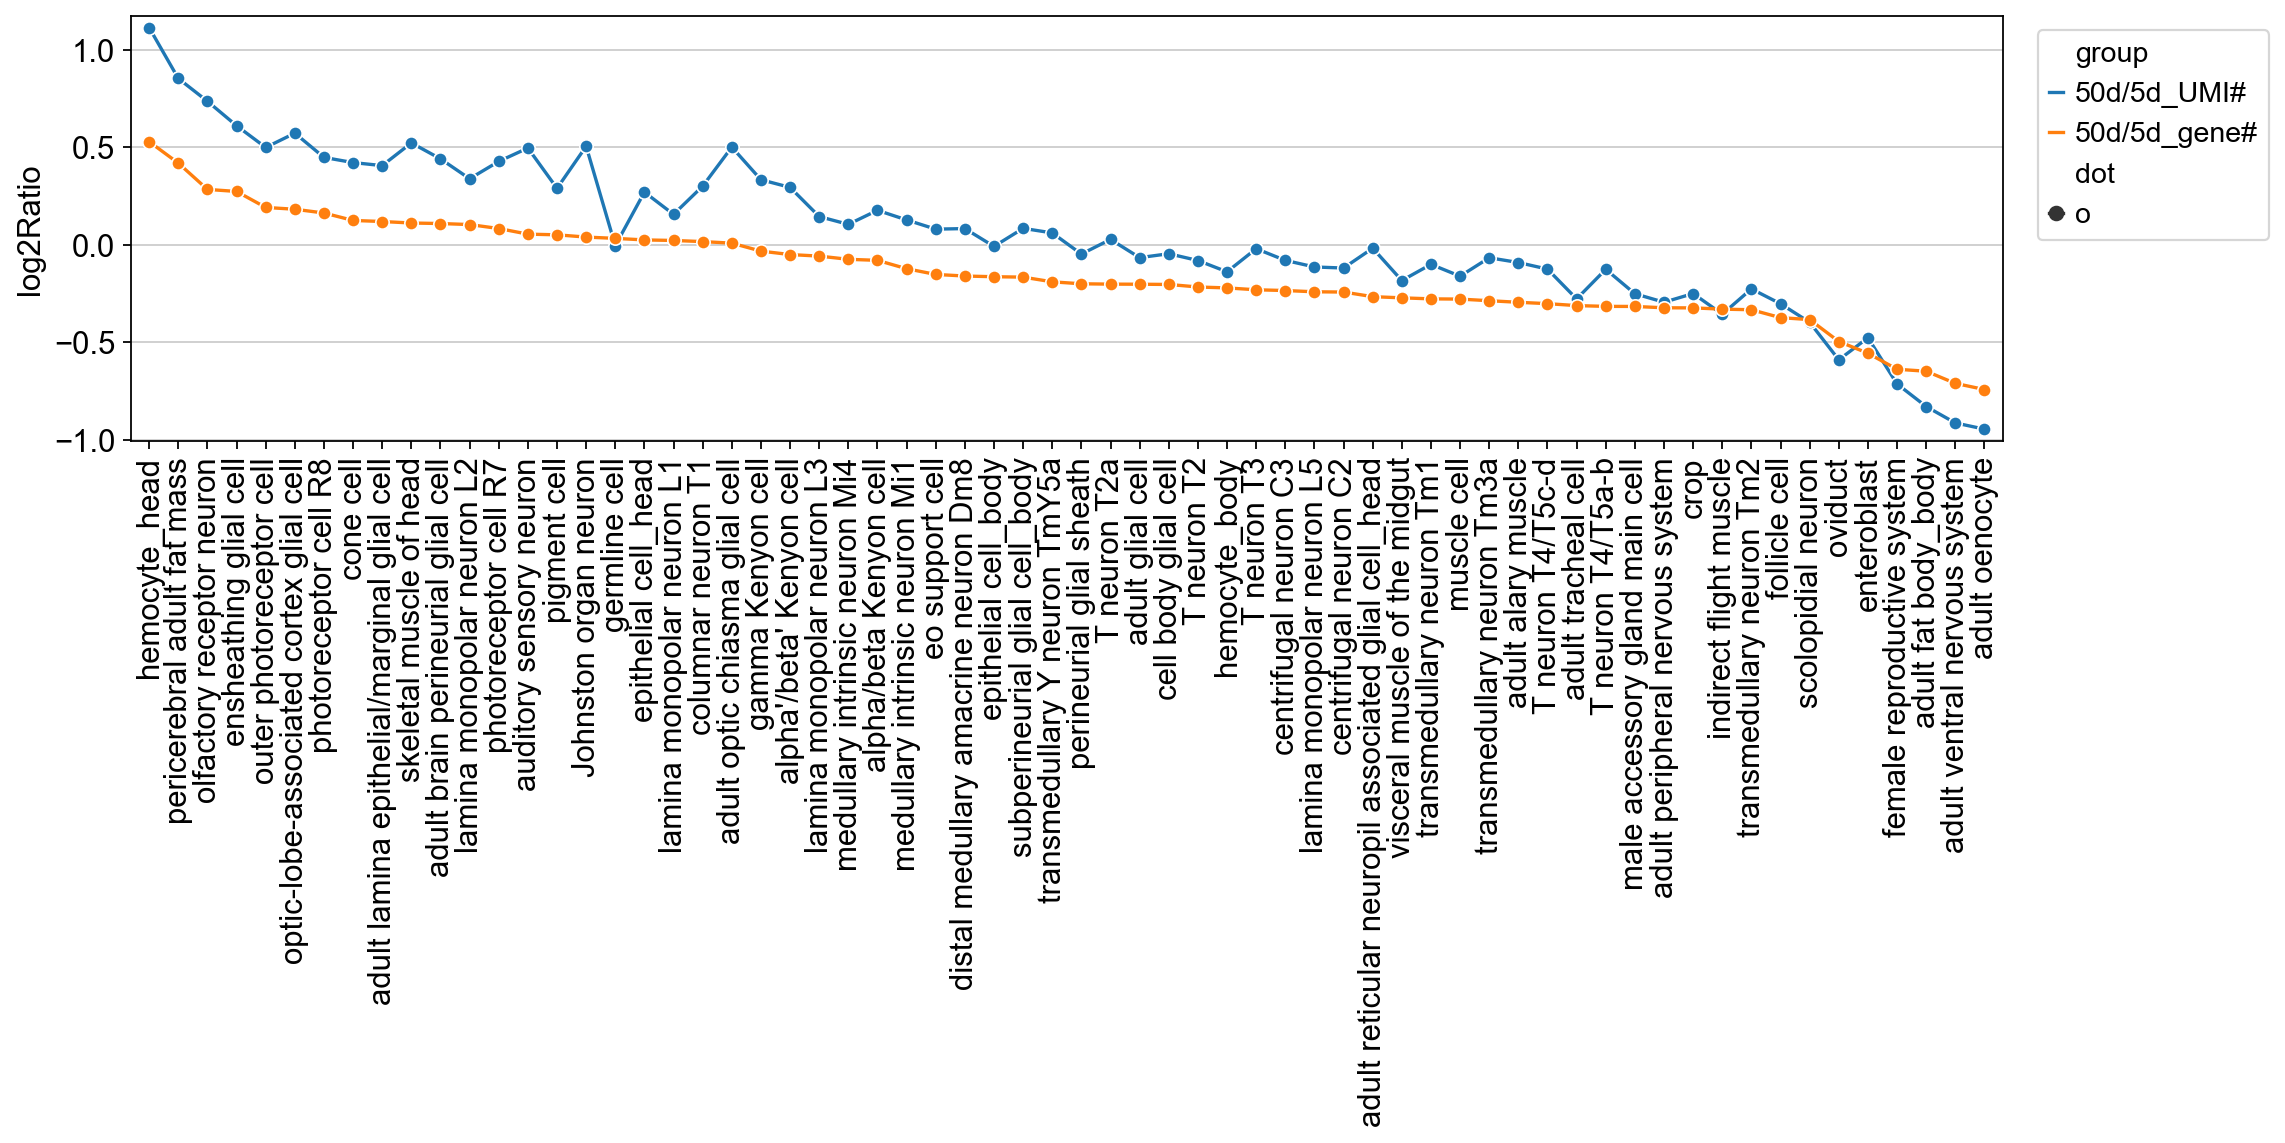

In [67]:
with rc_context({'figure.figsize': (15, 3.5)}):
    fig, ax = plt.subplots()
    
    ax.margins(0.01, 0.03)
    ax.grid(axis='x',visible=False)
    
    sns.lineplot(data=umi_geneN_mtx_long, x='annotation', y='log2Ratio', hue='group', markers=True, style='dot')
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.legend(bbox_to_anchor=(1.15, 1.0))
    
    plt.savefig(f'{figure5PicFolder}/log2Ratio_umi_geneN_50to5_sortbyGeneN.pdf', bbox_inches='tight')

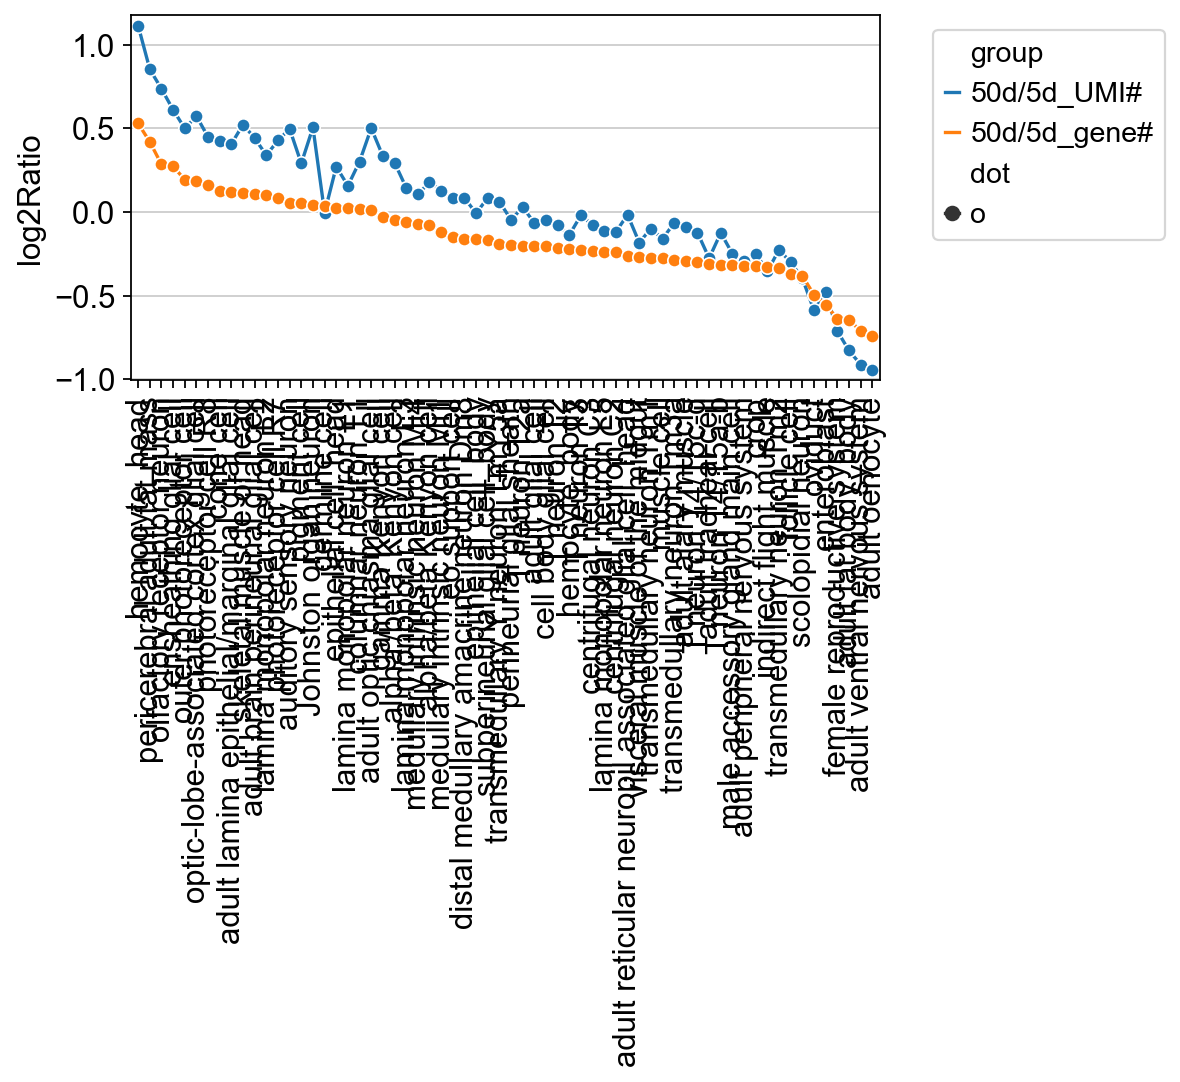

In [68]:
with rc_context({'figure.figsize': (6, 3)}):
    fig, ax = plt.subplots()
    
    ax.margins(0.01, 0.03)
    ax.grid(axis='x',visible=False)
    
    sns.lineplot(data=umi_geneN_mtx_long, x='annotation', y='log2Ratio', hue='group', markers=True, style='dot', color=['#9ecae1','#3182bd'])
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.legend(bbox_to_anchor=(1.4, 1.0))
    
    # plt.savefig(f'{figure5PicFolder}/log2Ratio_umi_geneN_50to5_sortbyGeneN_narrow.pdf', bbox_inches='tight')

In [57]:
geneN_mtx=pd.DataFrame({'50d/5d_gene#': geneN_Median_mtx_filtered['50d/5d_log2ratio']})
geneN_mtx.sort_values(by='50d/5d_gene#', inplace=True, ascending=False)
geneN_mtx['annotation'] = geneN_mtx.index.to_list()
geneN_mtx

50d/5d_gene#                    annotation
hemocyte_head                     0.528664                 hemocyte_head
pericerebral adult fat mass       0.418666   pericerebral adult fat mass
olfactory receptor neuron         0.284050     olfactory receptor neuron
ensheathing glial cell            0.273501        ensheathing glial cell
outer photoreceptor cell          0.191610      outer photoreceptor cell
...                                    ...                           ...
enteroblast                      -0.555519                   enteroblast
female reproductive system       -0.637518    female reproductive system
adult fat body_body              -0.647621           adult fat body_body
adult ventral nervous system     -0.709878  adult ventral nervous system
adult oenocyte                   -0.741369                adult oenocyte

[64 rows x 2 columns]

In [58]:
geneN_mtx_long = geneN_mtx.melt(id_vars=['annotation'], value_vars=['50d/5d_gene#'], var_name=['group'], value_name='log2Ratio')
geneN_mtx_long['dot']='o'
geneN_mtx_long

annotation         group  log2Ratio dot
0                  hemocyte_head  50d/5d_gene#   0.528664   o
1    pericerebral adult fat mass  50d/5d_gene#   0.418666   o
2      olfactory receptor neuron  50d/5d_gene#   0.284050   o
3         ensheathing glial cell  50d/5d_gene#   0.273501   o
4       outer photoreceptor cell  50d/5d_gene#   0.191610   o
..                           ...           ...        ...  ..
59                   enteroblast  50d/5d_gene#  -0.555519   o
60    female reproductive system  50d/5d_gene#  -0.637518   o
61           adult fat body_body  50d/5d_gene#  -0.647621   o
62  adult ventral nervous system  50d/5d_gene#  -0.709878   o
63                adult oenocyte  50d/5d_gene#  -0.741369   o

[64 rows x 4 columns]

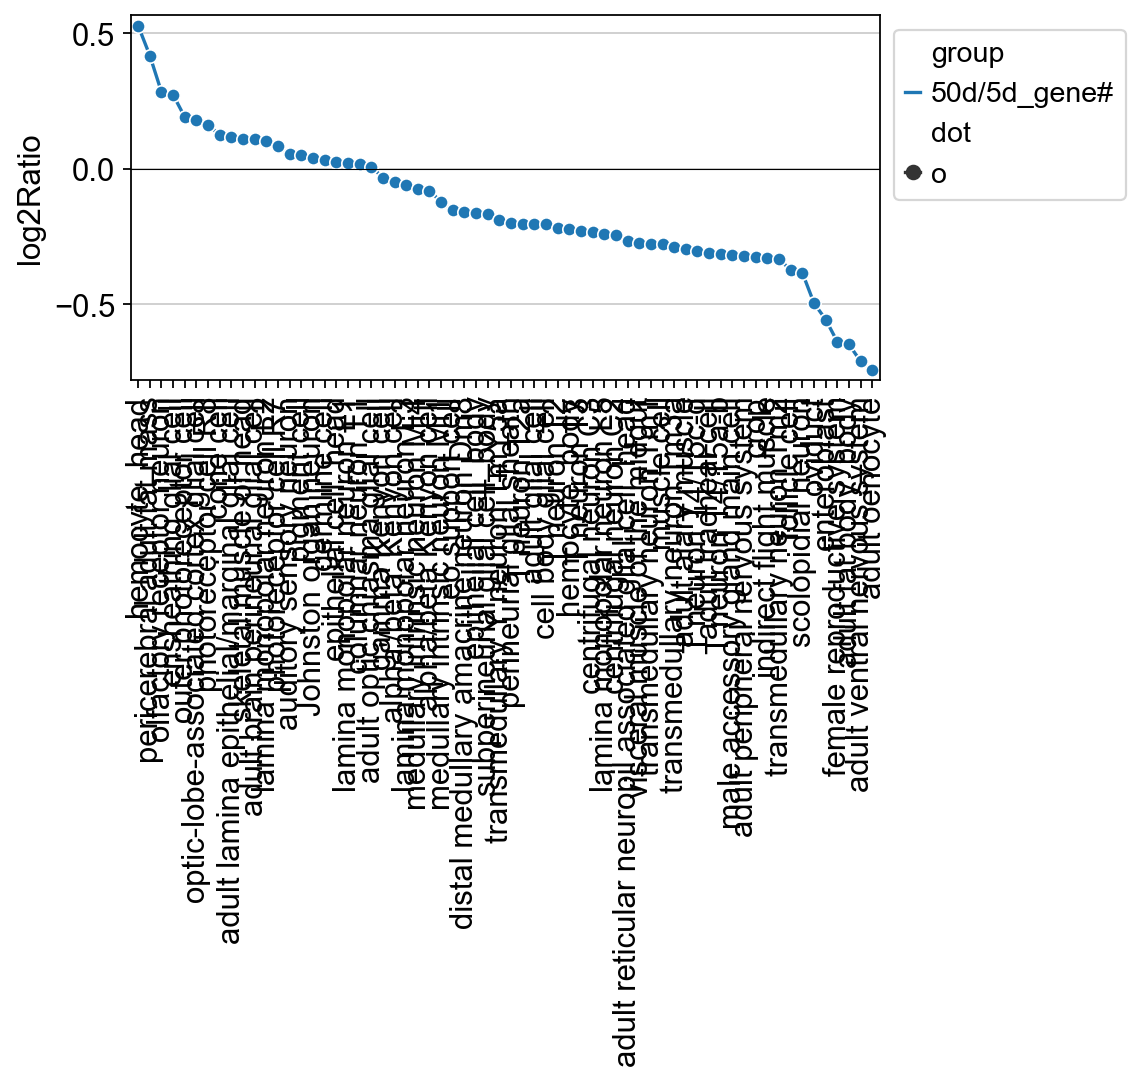

In [59]:
with rc_context({'figure.figsize': (6, 3)}):
    fig, ax = plt.subplots()
    
    ax.margins(0.01, 0.03)
    ax.grid(axis='x',visible=False)
    
    sns.lineplot(data=geneN_mtx_long, x='annotation', y='log2Ratio', hue='group', markers=True, style='dot')
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.axhline(y=0, c='black', linewidth=0.5)
    
    
    plt.savefig(f'{figure5PicFolder}/log2Ratio_geneN_50to5_sortby50d_geneN.pdf', bbox_inches='tight')